---
# Predicting Loan Repayment Capability: A Credit Risk Odyssey

**Author:** Martynas Loveikis

---
## Table of Contents

1. [Introduction](#introduction)
2. [Mission Objective](#mission-objective)
3. [Action Plan](#action-plan)
4. [Libraries](#libraries)
5. [Datasets](#dataset-sneakpeak)
6. [Data Cleaning](#dataset-cleaning)
7. [Exploratory Data Analysis](#exploratory-data-analysis)
8. [Statistical Inference](#statistical-inference)
9. [Data Preparation and Preprocessing](#data-preparation-and-preprocessing)
10. [Model Evaluation](#model-evaluation)
11. [Kaggle Submission](#kaggle-submission-the-final-showdown)
12. [Results](#results)
13. [Conclusion](#conclusion)
___
## introduction

___

This project: Predicting who will repay their loans and who won't. **Basically, we're financial detectives analyzing the credit behavior of loan applicants to uncover repayment potential.** Challenging, but rewarding.


___
## mission-objective

The goal? **Predict who will repay their loans and who won't.** Sounds straightforward, but the data has other plans. Time to untangle the web of credit history, spending habits, and loan applications.

___
## action-plan

Right, so the grand plan to predict loan repayment is:

*   **Data Retrieval and Cleaning:** Gather the data. Handle missing values. *Thrilling*.
*   **Exploratory Data Analysis:** Create charts like this one. Spot trends. *Exciting*.
*   **Feature Engineering:** Build new variables. Drop noisy ones. *Creative genius*.
*   **Predictive Modeling:** Train machine learning models. Predict defaults. *Fingers crossed*.
*   **Reporting and Recommendations:** Wrap it all up. Share insights. *The finale*.


---
## libraries

In [30]:
import contextlib
import gc
import os
import pickle
import subprocess
import shap
import warnings
import zipfile


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, IFrame, Image
from kaggle.api.kaggle_api_extended import KaggleApi
from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import (classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from ydata_profiling import ProfileReport

import src.data.clean as clean
import src.models.train_eval as models
import src.stats.test as stats
import src.visual.plotting as visual


warnings.filterwarnings("ignore")

## Import Extravaganza: The Kitchen Sink Approach

**System Utilities:**
- contextlib, gc, os, subprocess, warnings, zipfile

**Data & Visualization:**
- numpy, pandas, matplotlib
- IPython display tools

**Machine Learning Arsenal:**
- Kaggle API (for data acquisition)
- LightGBM & XGBoost (the heavy hitters)
- Sklearn's finest (metrics, model selection, ensembling)
- YData profiling (for fancy reports)

**Custom Modules:**
- data.clean (for data hygiene)
- models.train_eval (for model training)
- stats.test (for statistical validation)
- visual.plotting (for pretty pictures)

*Warning suppression included because we're brave data scientists who don't need no stinkin' warnings!*


In [2]:
HTML(
	"""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
"""
)

plt.rcParams.update(
	{
		"font.family"          : "monospace",
		"axes.titlesize"       : 10,
		"axes.titlepad"        : 13,
		"axes.labelsize"       : 10,
		"xtick.labelsize"      : 10,
		"ytick.labelsize"      : 10,
		"legend.fontsize"      : 9,
		"legend.title_fontsize": 9,
	}
)

pd.set_option("display.float_format", "{:,.3f}".format)

Styling the output because default plots are *too mainstream*. We've got custom fonts with meticulously adjusted font sizes. Also, limiting floats to 3 decimal places because, *precision*.

In [9]:
api = KaggleApi()
api.authenticate()

competition_name = "home-credit-default-risk"
target_path = "../data/credit_risk_raw"

api.competition_download_files(competition_name, path=target_path)

with zipfile.ZipFile(f"{target_path}/{competition_name}.zip", "r") as zip_ref:
    zip_ref.extractall(target_path)

Downloading "home-credit-default-risk" dataset via Kaggle API. Unzipping. Because who has time for *actual* effort?

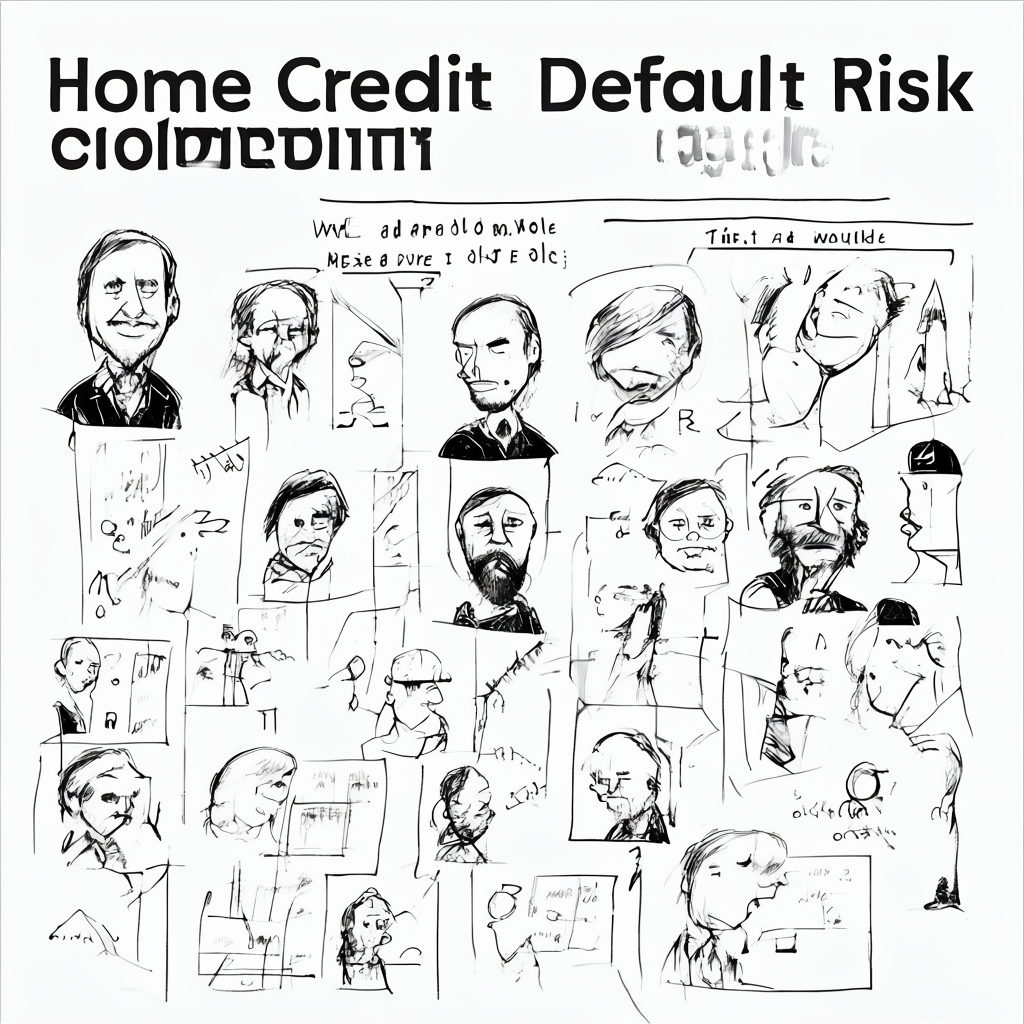

In [3]:
Image(filename="../images/title_photo.png")

---
## dataset-sneakpeak

### Data Tables: A Financial Soap Opera

**application_train**: The protagonist - one row per loan, split into Train (with TARGET) and Test (without TARGET). *Spoiler alert:* some will default.

**bureau**: The backstory - previous credits from other institutions. Like exes, they follow you everywhere.

**bureau_balance**: Monthly balances of those exes. *Thrilling* historical documentation.

**POS_CASH_balance**: Monthly snapshots of POS and cash loans. Because *nothing* says excitement like point-of-sale history.

**credit_card_balance**: Credit card snapshots. Watch those balances rise and fall like a *tragic* financial rollercoaster.

**previous_application**: Previous loan application records. The *rejected* suitors of credit history.

**installments_payments**: Repayment history - both paid and missed. The *walk of shame* in tabular form.

Profile Reports incoming. Brace for *riveting* insights.


In [2]:
df = pd.read_csv("../data/credit_risk_raw/"
                 "application_train.csv")
data_to_test = pd.read_csv("../data/credit_risk_raw/"
                      "application_test.csv")
bureau = pd.read_csv("../data/credit_risk_raw/"
                     "bureau.csv")
bureau_balance = pd.read_csv("../data/credit_risk_raw/"
                             "bureau_balance.csv")
credit_card_balance = pd.read_csv("../data/credit_risk_raw/"
                                  "credit_card_balance.csv")
installments_payments = pd.read_csv("../data/credit_risk_raw/"
                                    "installments_payments.csv")
pos_cash_balance = pd.read_csv("../data/credit_risk_raw/"
                               "POS_CASH_balance.csv")
previous_application = pd.read_csv("../data/credit_risk_raw/"
                                   "previous_application.csv")

### `optimize_dtypes`: The DataFrame Dietician

**Purpose:** Puts your DataFrame on a strict byte-counting regimen by:
- Shrinking integers until they're *practically microscopic*
- Compressing floats to the *bare minimum* required to stay afloat
- Converting objects to categories *only when it makes sense* 

Returns a slimmer DataFrame that won't make your RAM weep uncontrollably.


In [5]:
df = clean.optimize_dtypes(df)
data_to_test = clean.optimize_dtypes(data_to_test)
bureau = clean.optimize_dtypes(bureau)
bureau_balance = clean.optimize_dtypes(bureau_balance)
credit_card_balance = clean.optimize_dtypes(credit_card_balance)
installments_payments = clean.optimize_dtypes(installments_payments)
pos_cash_balance = clean.optimize_dtypes(pos_cash_balance)
previous_application = clean.optimize_dtypes(previous_application)

### Creating a Profile Report
*Generating a fancy HTML report that we'll glance at for 30 seconds before getting back to actual coding*

Then deleting it from memory because apparently we're too good for garbage collection.


In [ ]:
train_profile = ProfileReport(df,
                              title="Train application",
                              progress_bar=False,
                              minimal=True)
train_profile.to_file("../reports/train_report.html")
del train_profile

In [100]:
IFrame("https://mlovei.github.io/html-pages/TC3_4/train_report.html",
       width=900, height=600)

### Loan Data: Numbers That Will Make You Question Your Life Choices

**The Basics:**
- 122 variables (because *clearly* we needed that many)
- 307K observations (humans reduced to spreadsheet fodder)
- 24.4% missing cells (the data analyst's version of Swiss cheese)

**What's Inside:** Client info ranging from income to whether they own a toaster, all to determine if they'll default on loans. Includes:
- Personal details (income, family status, employment—all the things you *lie about* on dating profiles)
- Loan specifics (amount, annuity, type—the financial equivalent of "how deep in trouble are you?")
- Housing info (because your apartment's basement apparently determines creditworthiness)

**Data Quality Issues:**
- Missing values coded as "XNA" (the dataset's way of saying "¯\_(ツ)_/¯")
- Organization type with 58 distinct values (someone got *really creative* with job titles)
- Features with up to 70% missing values (more holes than your excuses for late payments)
- Highly skewed numeric features (because normal distributions are *so* mainstream)
- Excessive zeros (like your bank account after loan approval)


In [ ]:
bureau_profile = ProfileReport(bureau,
                               title="bureau report",
                               progress_bar=False)
bureau_profile.to_file("../reports/bureau_report.html")
del bureau_profile

In [13]:
IFrame("https://mlovei.github.io/html-pages/TC3_4/bureau_report.html",
       width=900, height=650)

In [ ]:
bureau_balance_profile = ProfileReport(bureau_balance,
                                       title="bureau balance report",
                                       progress_bar=False)
bureau_balance_profile.to_file("../reports/bureau_balance_report.html")
del bureau_balance_profile

In [14]:
IFrame("https://mlovei.github.io/html-pages/TC3_4/bureau_balance_report.html",
       width=900, height=650)

### Credit Bureau Data: Financial Skeletons in Digital Closets

**Bureau Table:**
- 17 variables, 1.7M observations, 13.5% missing data
- Contains: loan status, currency, duration metrics, overdue status, debt amounts
- Features financial regrets in convenient tabular format

**Bureau Balance Table:**
- 3 variables, 27.3M entries, suspiciously perfect (0% missing)
- Minimalism at its finest

**Data Quality Issues:**
- High correlations (redundancy as an art form)
- Imbalance, skewness, missing data, excessive zeros
- Statistical nightmares disguised as insights

In [ ]:
credit_card_balance_profile = ProfileReport(credit_card_balance,
                                            title="credit card balance report",
                                            progress_bar=False,
                                            minimal=True)
credit_card_balance_profile.to_file(
"../reports/credit_card_balance_report.html")
del credit_card_balance_profile

In [15]:
IFrame("https://mlovei.github.io/html-pages/TC3_4/credit_card_balance_report.html",
       width=900, height=600)

### Credit Card Balance: Your Financial Regrets, Tabulated

**Stats:**
- 23 variables, 3.8M observations, 6.7% missing values
- Tracks: monthly balances, credit limits, ATM withdrawals, purchases
- Records payments, receivables, and contract status

**Quality Issues:**
- Skewed distributions (like your spending habits)
- Correlated features (redundancy is efficient, said no one ever)
- Imbalanced contract status (mostly 'active'—debt never dies)

In [ ]:
installments_payments_profile = ProfileReport(installments_payments,
                                              title="installments "
                                                    "payments report",
                                              progress_bar=False)
installments_payments_profile.to_file(
    "../reports/installments_payments_report.html")
del installments_payments_profile

In [16]:
IFrame("https://mlovei.github.io/html-pages/TC3_4/installments_payments_report.html",
       width=900, height=650)

### Installments Table: Where Payment Promises Go to Die

**The Basics:**
- 8 variables (refreshingly restrained)
- 14M observations (that's a lot of broken promises)
- <0.1% missing values (suspiciously complete)

**Contents:**
- Installment calendar versions (bureaucracy at its finest)
- Installment numbers (counting your financial obligations)
- Scheduled vs. actual payment dates (expectation vs. reality)
- Prescribed amounts vs. actual payments (more expectation vs. reality)

**Quality:**
- Highly correlated features (because one way to measure lateness wasn't enough)
- Otherwise mysteriously clean (the data equivalent of "too good to be true")

In [ ]:
POS_CASH_balance_profile = ProfileReport(pos_cash_balance,
                                         title="POS CASH balance report",
                                         progress_bar=False)
POS_CASH_balance_profile.to_file("../reports/POS_CASH_balance_report.html")
del POS_CASH_balance_profile

In [17]:
IFrame("https://mlovei.github.io/html-pages/TC3_4/POS_CASH_balance_report.html",
       width=900, height=650)

### POS Cash Table: Where Retail Therapy Meets Financial Reality

**Stats:**
- 8 variables, 10M observations, 0.1% missing values
- Tracks: monthly balances, credit terms, remaining installments
- Records contract status and days past due (with and without tolerance)

**Issues:**
- Imbalanced contract status (because consistency is boring)
- One highly skewed feature (statistical normality is overrated)

In [ ]:
previous_application_profile = ProfileReport(previous_application,
                                             title="previous "
                                                   "application report",
                                             progress_bar=False,
                                             minimal=True)
previous_application_profile.to_file(
    "../reports/previous_application_report.html")
del previous_application_profile

In [18]:
IFrame("https://mlovei.github.io/html-pages/TC3_4/previous_application_report.html",
       width=900, height=600)

### Previous Application Table: The Graveyard of Financial Hopes

**Stats:**
- 37 variables (because 36 wouldn't capture enough rejection)
- 1.7M observations (that's a lot of desperate attempts)
- 18% missing cells (the data equivalent of ghosting)

**Contents:**
- Contract types, credit amounts, down payments
- Loan purposes (dreams that required financing)
- Application timestamps (documenting exactly when hope existed)
- Decision dates (when dreams were crushed or validated)
- Client status flags (new or returning to the financial pain)

**Quality Issues:**
- Highly correlated features (redundancy is an art form)
- Imbalance and skewness (statistical nightmares)

In [6]:
gc.collect()

64

---
## dataset-cleaning
### *The Bare Minimum Approach*

Ignoring most data issues because *who has time for proper cleaning?* Only the application table gets the VIP treatment.

We'll let our models deal with the statistical nightmares later. That's what algorithms are for, right?


In [3]:
df_EDA = clean.clean_creditrisk(df)
data_to_test = clean.clean_creditrisk(data_to_test)

---
## exploratory-data-analysis
Examining the dataset to gain "insights" and "understand characteristics"—corporate speak for "staring at numbers until patterns emerge or we get bored."

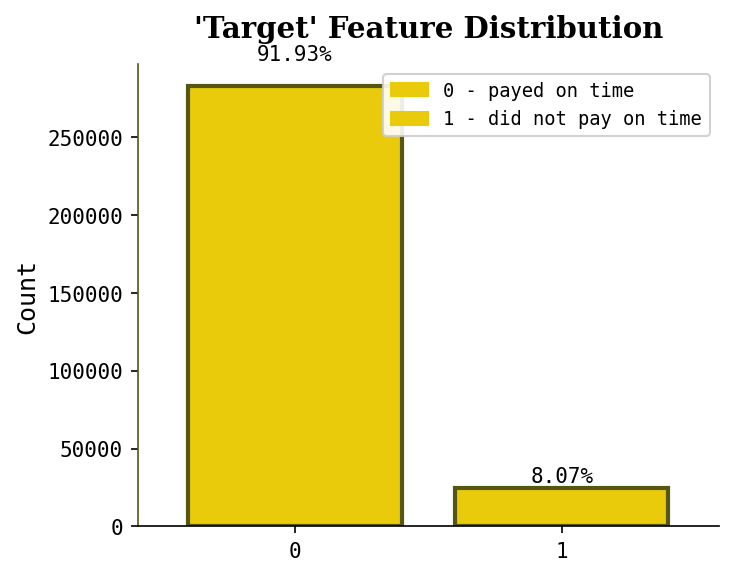

In [21]:
visual.barcharts_by_group(df_EDA,['TARGET'],show_legend=True,
                   legend_labels=['0 - payed on time',
                                  '1 - did not pay on time'])

### Target Variable: The Binary Drama

**1:** Client with payment difficulties (*translation:* late payment > X days in at least Y installments).  
**0:** Everyone else (*aka:* the lucky 92%).

*Spoiler alert:* The dataset is about as balanced as a one-legged stool.


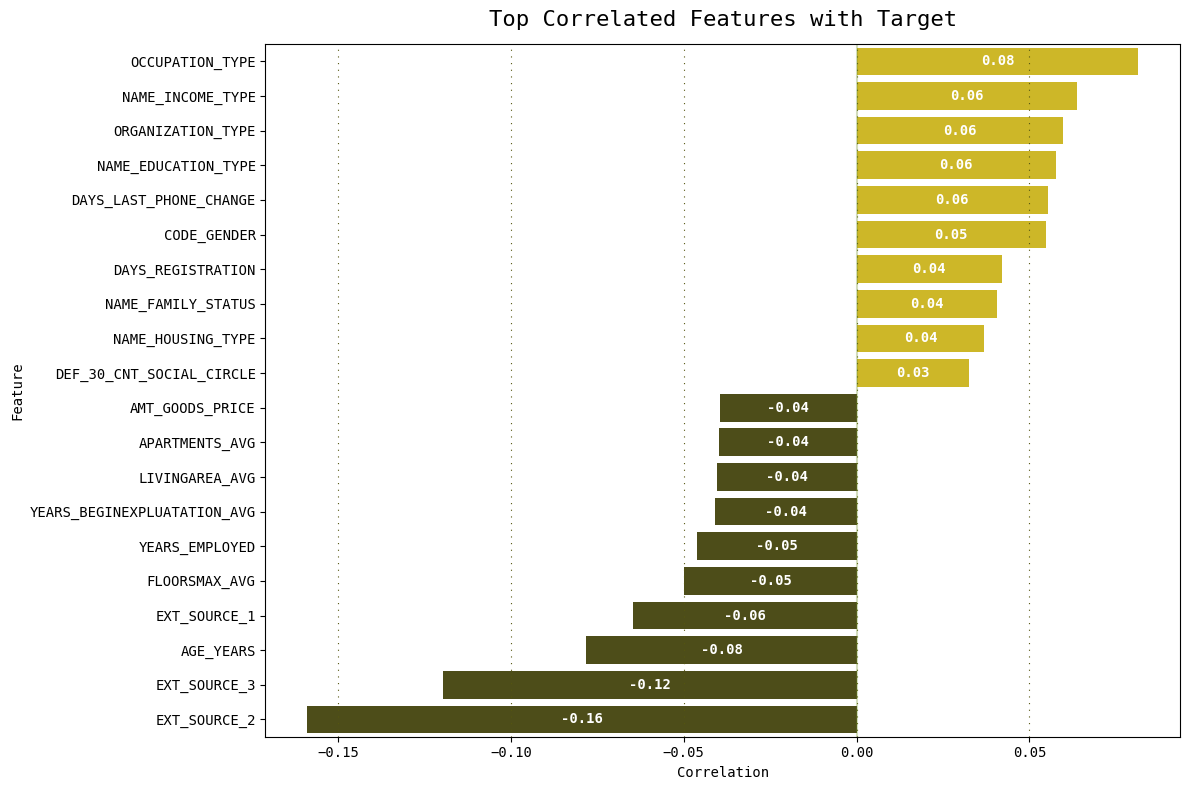

In [22]:
top_features = stats.analyze_feature_correlations(df_EDA, top_n=10)

### Correlations with Target Variable: Summary

The chart reveals **key features** linked to the target variable.

**Highlights:**
- **Top Positives:** `OCCUPATION_TYPE`, `NAME_INCOME_TYPE`, and `ORGANIZATION_TYPE`—because your job and income source apparently matter.
- **Top Negatives:** External scores (`EXT_SOURCE_2`, `EXT_SOURCE_3`) and `AGE_YEARS`—older and higher scores mean less default risk.

**Conclusion:**
Correlations are weak, but external scores and demographics still steal the spotlight. Not thrilling, but worth a closer look.


In [4]:
categorical_cols = df_EDA.select_dtypes(include=['category',
                                                   'object']).columns.tolist()
numerical_cols = df_EDA.select_dtypes(
    include=['number']).drop('TARGET', axis=1).columns.tolist()
X, y = clean.preprocess_dataframe(df_EDA,categorical_cols, target_col='TARGET')

In [10]:
model_dir = '../deployment/'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model = XGBClassifier(random_state=42, verbosity=0,
                      scale_pos_weight=(91.93/8.07))

with open(os.devnull, "w") as fnull:
    with contextlib.redirect_stdout(fnull):
        model.fit(X, y)
filename = os.path.join(model_dir, 'xgboost_model.pkl')
pickle.dump(model, open(filename, 'wb'))
print(f"Model saved to {filename}")

Model saved to ../deployment/xgboost_model.pkl


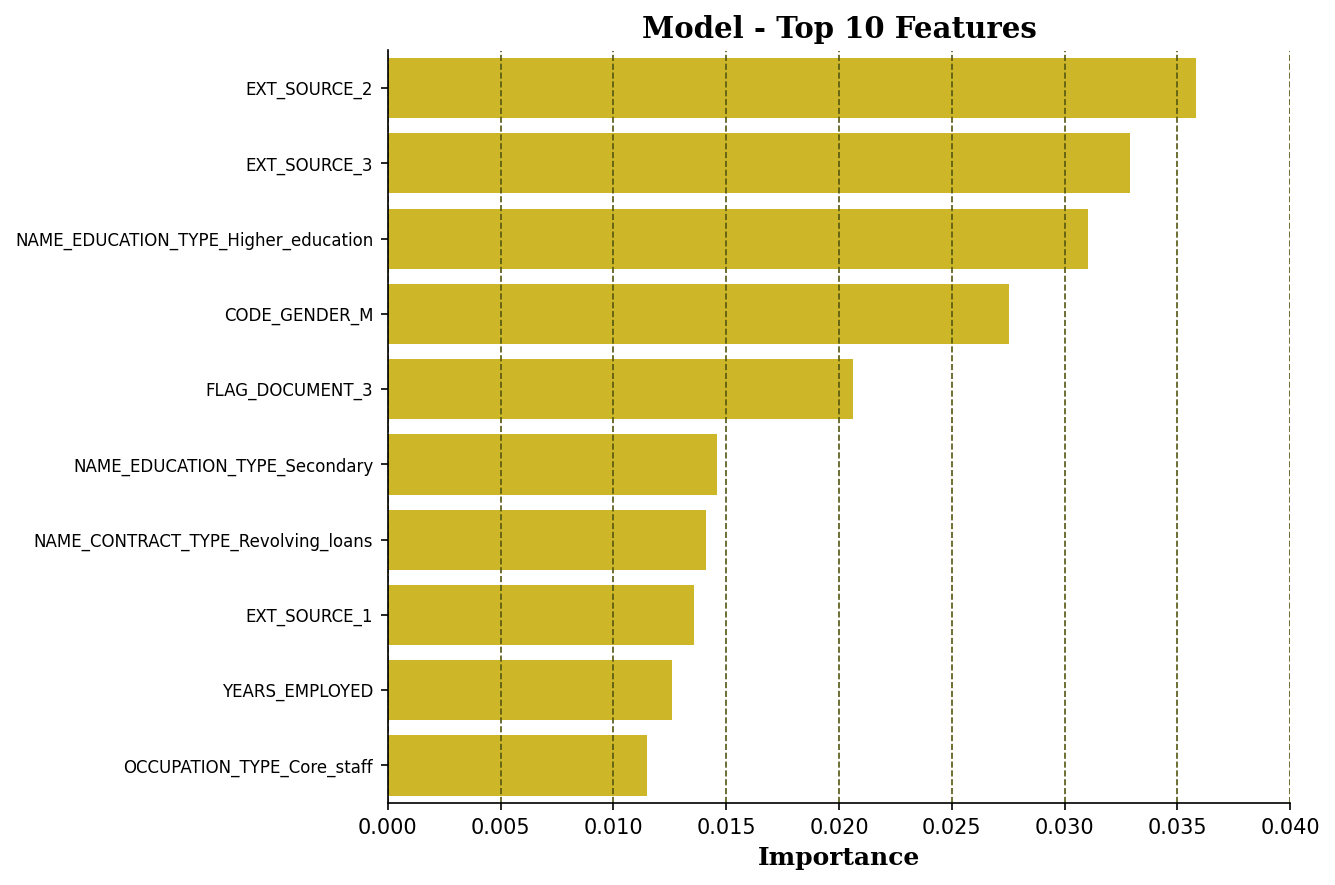

**27 features** were found below threshold 0.001

In [6]:
_ = models.feature_importances(model,X, importance_threshold = 0.001,
                               xmin = 0, xmax = 0.04, figsize = (9,6))

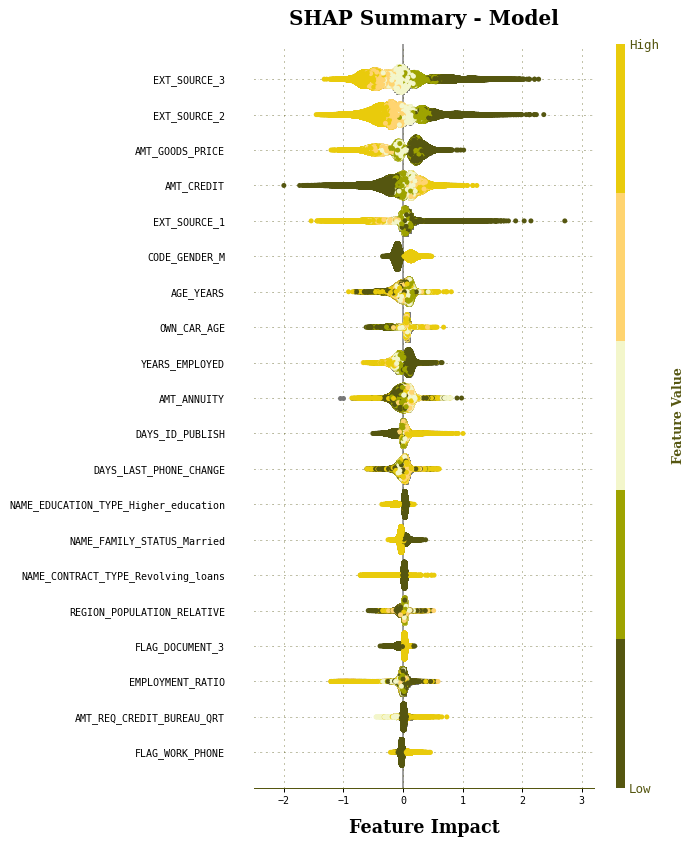

In [11]:
models.shap_summary(model,X)

### SHAP Summary Plot: Feature Importance

The SHAP summary plot lays bare the **most impactful features** steering model predictions. Let’s break it down:

**Key Insights:**
- **External Scores Steal the Show:** `EXT_SOURCE_3`, `EXT_SOURCE_2`, and `EXT_SOURCE_1` are the undisputed stars. Higher values? Lower default risk. It’s like they’re the teachers’ pets of the dataset.
- **Loan Features Hold Their Ground:** `AMT_GOODS_PRICE` and `AMT_CREDIT` remind us that money talks—loan amounts clearly influence predictions.
- **Demographics & History Add Spice:** Features like `AGE_YEARS`, `YEARS_EMPLOYED`, and `DAYS_ID_PUBLISH` bring depth, proving that who you are and your financial history matter.

**Conclusion:**
External scores dominate the narrative, while loan metrics and demographic factors provide supporting roles. In short, if your external score is high, your age is mature, and your loan isn’t outrageous, you’re golden. Everyone else? Good luck.


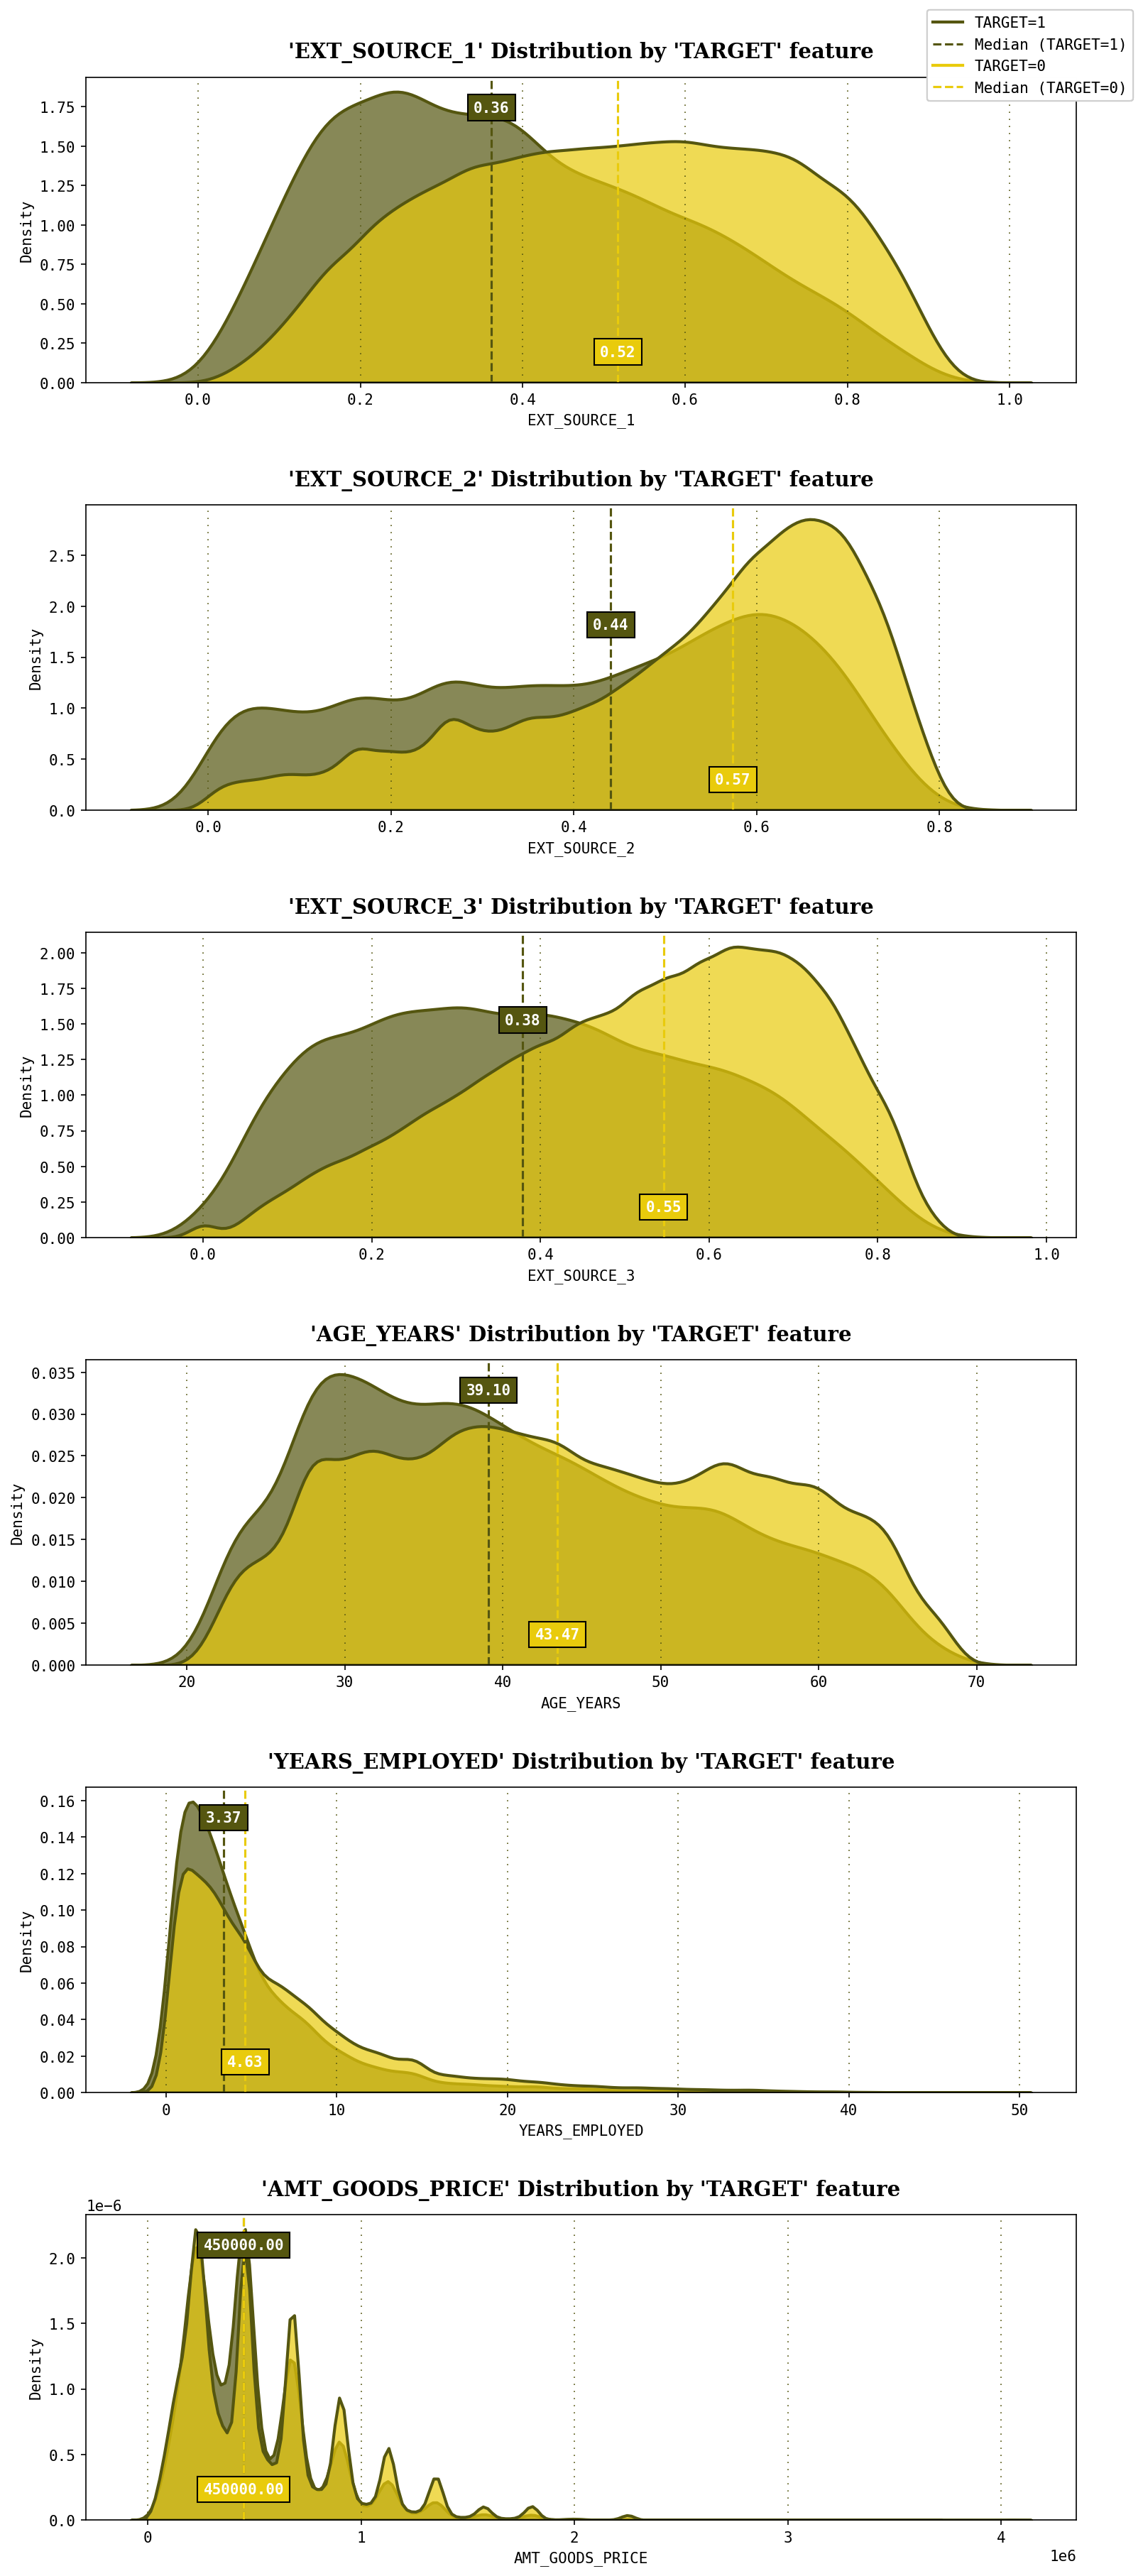

In [27]:
numerical_features = [
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "AGE_YEARS",
    "YEARS_EMPLOYED",
    "AMT_GOODS_PRICE"
]
visual.graph_by_group(df_EDA,
                      target_variables=numerical_features,
                      group_variable='TARGET')

### KDE Plot Insights: Feature Distributions by Target Variable

**Key Observations:**
- **Higher Scores, Lower Risk:** Clients without payment issues flaunt higher external scores (`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`). Apparently, being "externally sourced" makes you less risky—who knew?
- **Employment Duration:** Longer employment years equal fewer defaults. Shocker: having a stable job actually helps you pay your bills.
- **Age Factor:** Older clients are less likely to default, while the 20–30 crowd seems to think loans are optional suggestions.

**Conclusion:**
External scores, job stability, and age are the holy trinity of avoiding financial disaster. Translation? Be old, employed, and have great scores—or brace for default drama.


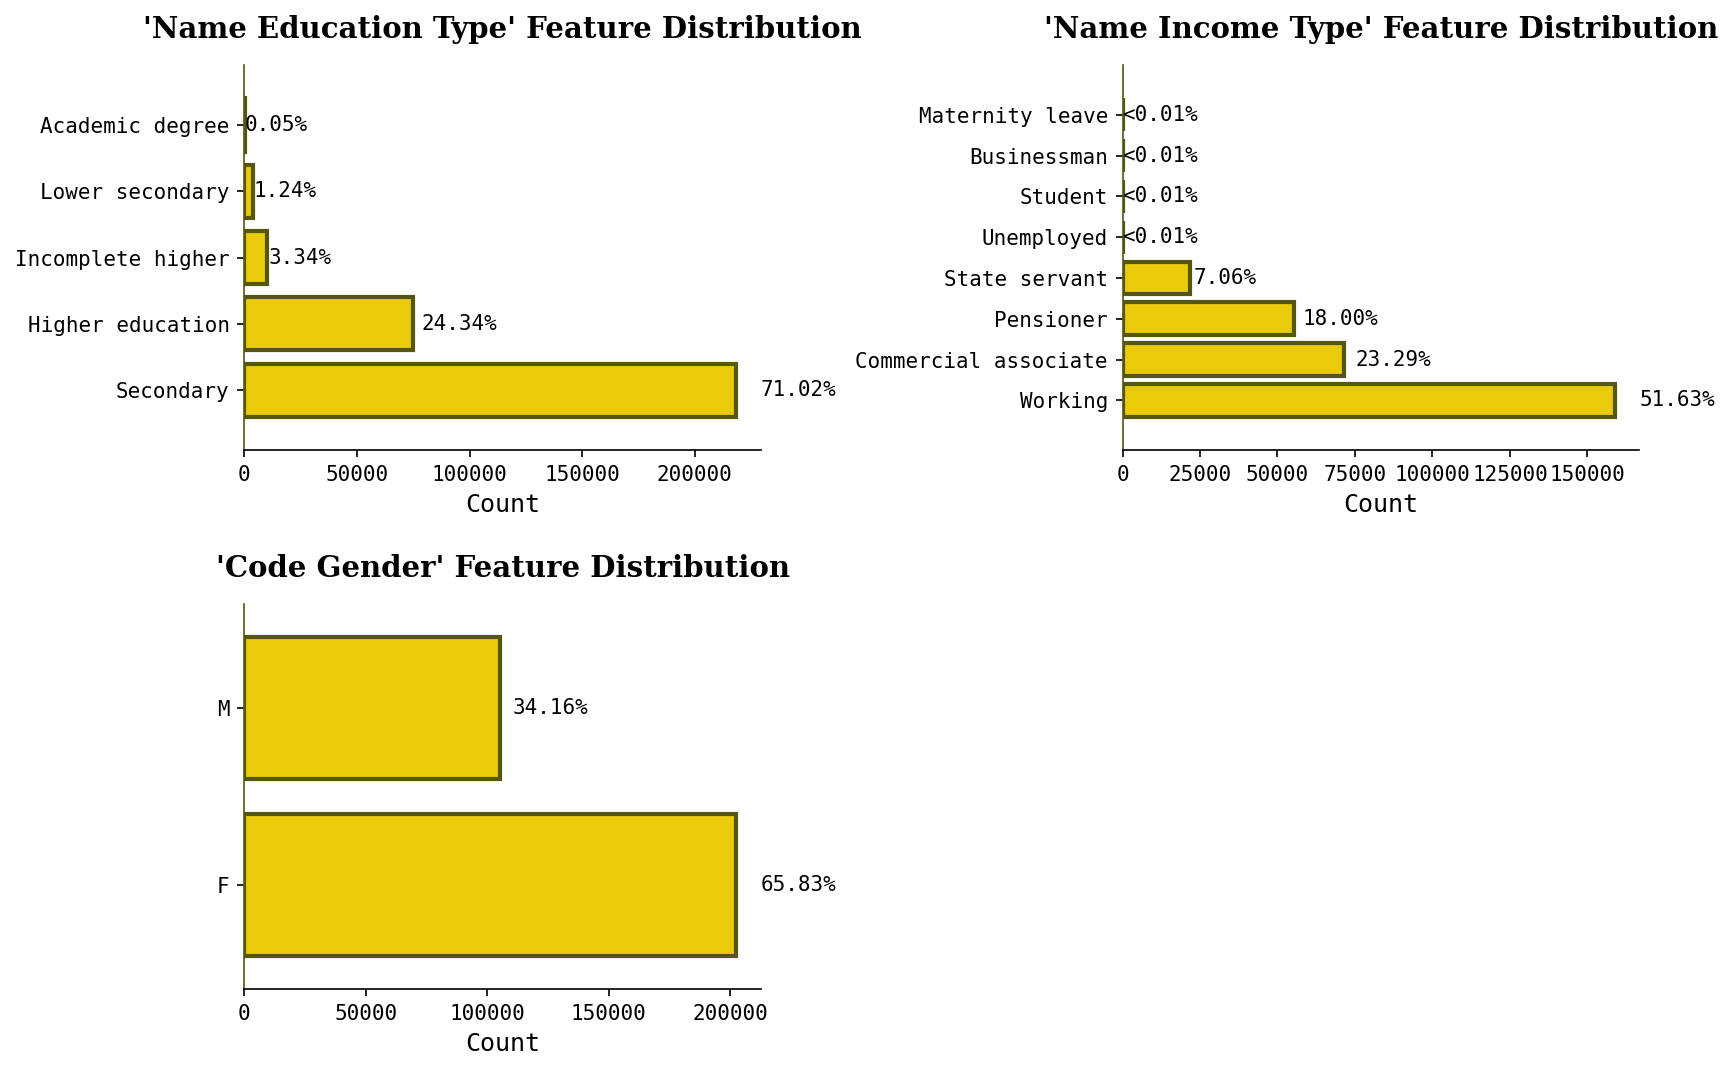

In [28]:
categorical_features = ["NAME_EDUCATION_TYPE",
                        "NAME_INCOME_TYPE",
                        "CODE_GENDER"]

visual.barcharts_by_group(df_EDA,categorical_features,
                          orientation='horizontal',wspace=0.7,hspace=0.4)

### Feature Distribution Summary

 **Education**
- **Secondary rules:** **71%** of clients bask in the glory of secondary education, while academic degrees? A mere *0.05%*. How... quaint.
- **Insight:** Higher education? Apparently, it breeds *reliability*. Who knew?

**Income Source**
- **Working *stiffs* dominate:** A staggering **51.63%** toil away, while commercial associates (**23.29%**) and pensioners (**18%**) reminisce about their glory days.
- **Insight:** Maternity leave and unemployment? *Microscopic* blips, yet they default like it's an Olympic sport.

**Gender**
- **Female *horde*:** Women, in their infinite wisdom, constitute **65.83%** of clients, leaving men to their... *34.16%*.
- **Insight:** Men default more. *Shocker*.

**Conclusion:** Secondary education, a steady paycheck, and ovaries? The trifecta of financial *mediocrity*.

---
# statistical-inference

Time to extrapolate wildly and call it 'statistical inference'. Let the data manipulation... *begin*.

**Target population**: 307,511 souls, all clients of Home Credit.

**Significance level (α)**: 0.05. *Because tradition, mostly.*

**H1 (Null):** `AGE_YEARS` Same for defaulters and non-defaulters. *Obviously.*

**H1 (Alternative):** `AGE_YEARS`  Different. *What a shocking revelation that would be.*

Before testing the `Age` hypothesis, let's check if the `Age` distribution is normal. **Because, as we've learned, data rarely cooperates.** *Spoiler alert: it won't.*

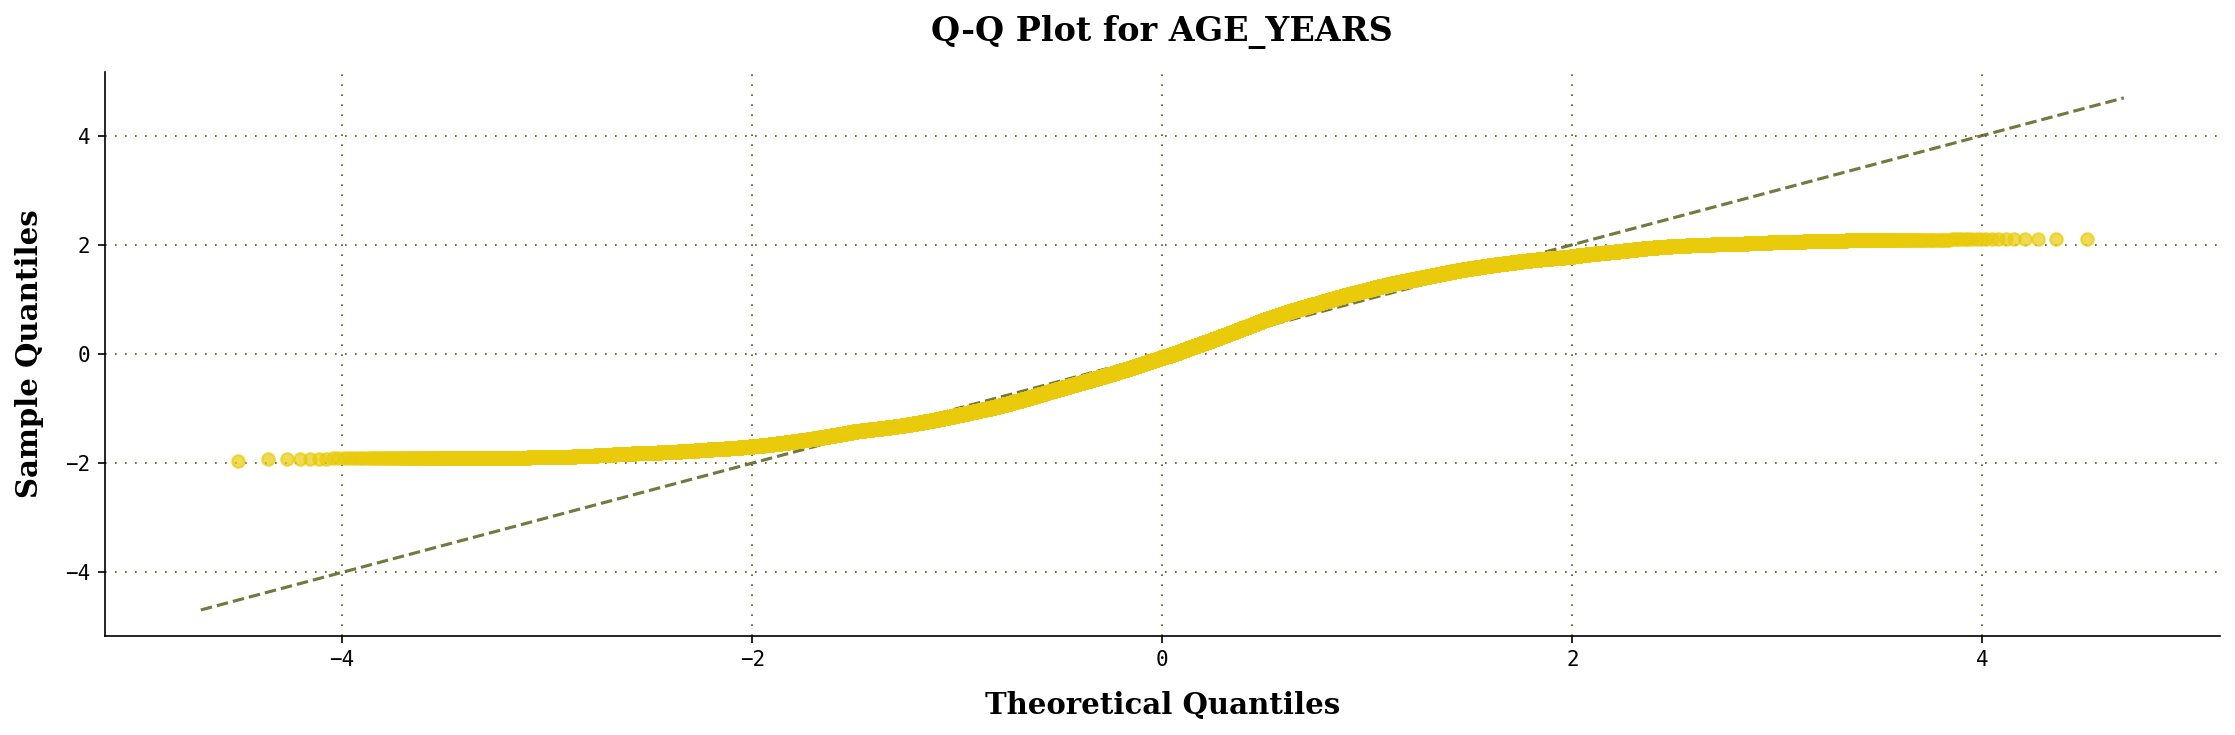

In [29]:
stats.dynamic_qq(df_EDA, ["AGE_YEARS"])

Q-Q plot for `AGE_YEARS`: A *mostly* straight line? *If you squint and ignore half the data.* Behold the *glorious* deviation, justifying our *need* for non-parametric tests.

In [30]:
stats.shapiro_test_by_tag(df_EDA, "TARGET",
                         "AGE_YEARS", display_output=True)

### Shapiro-Wilk Test Results:

**For TARGET = True:**

* Test Statistic: 0.962

* P-value: 0.000

**For TARGET = False:**

* Test Statistic: 0.970

* P-value: 0.000

Shapiro-Wilk: Non-normal (p=0.000). Non-parametric it is.

In [31]:
stats.non_parametric_test_by_tag(df_EDA, "TARGET",
                                "AGE_YEARS", display_output=True)

### Non-parametric Test Results (Mann-Whitney U) and Confidence Intervals:

**Confidence Level:** 95%

**For TARGET = True:**

* Mean Value: 40.75

* Confidence Interval: (40.61, 40.90)

**For TARGET = False:**

* Mean Value: 44.18

* Confidence Interval: (44.14, 44.23)

**Mann-Whitney U Test:**

* p-value = 0.000

Non-parametric: Defaulters younger. U-test: Different ages confirmed. *As if we didn't know.*

**H2 (Null):** Categorical variables? *Totally* unrelated.

**H2 (Alternative):** Categorical variables? *Shockingly* related.

In [32]:
categorical_hypothesis = [
    "CODE_GENDER",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "NAME_TYPE_SUITE",
    "NAME_CONTRACT_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_INCOME_TYPE",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY"
]

In [33]:
alpha = 0.05
num_comparisons = len(categorical_hypothesis)
bonferroni_alpha = alpha / num_comparisons
bonferroni_alpha

0.005555555555555556

### Bonferroni Correction: Statistical Overkill

Alpha = 0.05 ÷ 9 = 0.00555...

*When you absolutely, positively need to reject every false positive in the room.*

Nine categorical variables, one brutal correction. Your p-values must now limbo under a bar so low even statistical significance needs physical therapy afterward.


In [34]:
for hypothesis in categorical_hypothesis:
    stats.categorical_feature_tests(df_EDA, hypothesis, "TARGET",
                                    significance_level=bonferroni_alpha)

**`CODE_GENDER` vs `TARGET`**

* Chi-Squared Statistic: 920.006

* p-value: 0.000 **(< 0.0056)**

*Significant association found* **(Cramer's V: 0.055)**

**`NAME_FAMILY_STATUS` vs `TARGET`**

* Chi-Squared Statistic: 504.694

* p-value: 0.000 **(< 0.0056)**

*Significant association found* **(Cramer's V: 0.041)**

**`NAME_HOUSING_TYPE` vs `TARGET`**

* Chi-Squared Statistic: 420.556

* p-value: 0.000 **(< 0.0056)**

*Significant association found* **(Cramer's V: 0.037)**

**`NAME_TYPE_SUITE` vs `TARGET`**

* Chi-Squared Statistic: 32.825

* p-value: 0.000 **(< 0.0056)**

*Significant association found* **(Cramer's V: 0.010)**

**`NAME_CONTRACT_TYPE` vs `TARGET`**

* Chi-Squared Statistic: 293.151

* p-value: 0.000 **(< 0.0056)**

*Significant association found* **(Cramer's V: 0.031)**

**`NAME_EDUCATION_TYPE` vs `TARGET`**

* Chi-Squared Statistic: 1019.213

* p-value: 0.000 **(< 0.0056)**

*Significant association found* **(Cramer's V: 0.058)**

**`NAME_INCOME_TYPE` vs `TARGET`**

* Chi-Squared Statistic: 1253.471

* p-value: 0.000 **(< 0.0056)**

*Significant association found* **(Cramer's V: 0.064)**

**`FLAG_OWN_CAR` vs `TARGET`**

* Chi-Squared Statistic: 146.656

* p-value: 0.000 **(< 0.0056)**

*Significant association found* **(Cramer's V: 0.022)**

**`FLAG_OWN_REALTY` vs `TARGET`**

* Chi-Squared Statistic: 11.576

* p-value: 0.001 **(< 0.0056)**

*Significant association found* **(Cramer's V: 0.006)**

### Categorical Features vs TARGET: Chi-Squared Results

All features show **significant associations** (p < 0.0056), but strength varies dramatically.

#### **Association Strength:**
- **Strong-ish:** `NAME_INCOME_TYPE` (0.064), `NAME_EDUCATION_TYPE` (0.058), `CODE_GENDER` (0.055)
- **Mediocre:** `NAME_FAMILY_STATUS` (0.041), `NAME_HOUSING_TYPE` (0.037), `NAME_CONTACT_TYPE` (0.031)
- **Barely There:** `FLAG_OWN_CAR` (0.022),`FLAG_OWN_REALTY` (0.006), `NAME_TYPE_SUITE` (0.010)

#### **Conclusion:**
Income type, education, and gender lead the pack—though with these Cramer's V values, "leading" is like being the tallest dwarf.


___
# feature-engineering

### Data Merging Extravaganza: When Tables Collide

**The Plan:**
1. Smash all tables together into one mega-dataset
2. Conjure new features out of thin air (and math)

**The Challenge:**
Supplementary tables playing hard to get? No problem! We'll just:
- Group by current application ID
- Perform statistical voodoo

**The Arsenal:**
- Sum-moning spells
- Mean-ingful incantations
- Max-imum and Min-imum rituals
- Ratio-nal magic
- Difference engines
- Category creation sorcery

*Because why have simple, interpretable data when you can have a Frankenstein's monster of features?*

### Application

In [13]:
enhanced_application = clean.enhance_application_features(df_EDA)
data_to_test = clean.enhance_application_features(data_to_test)

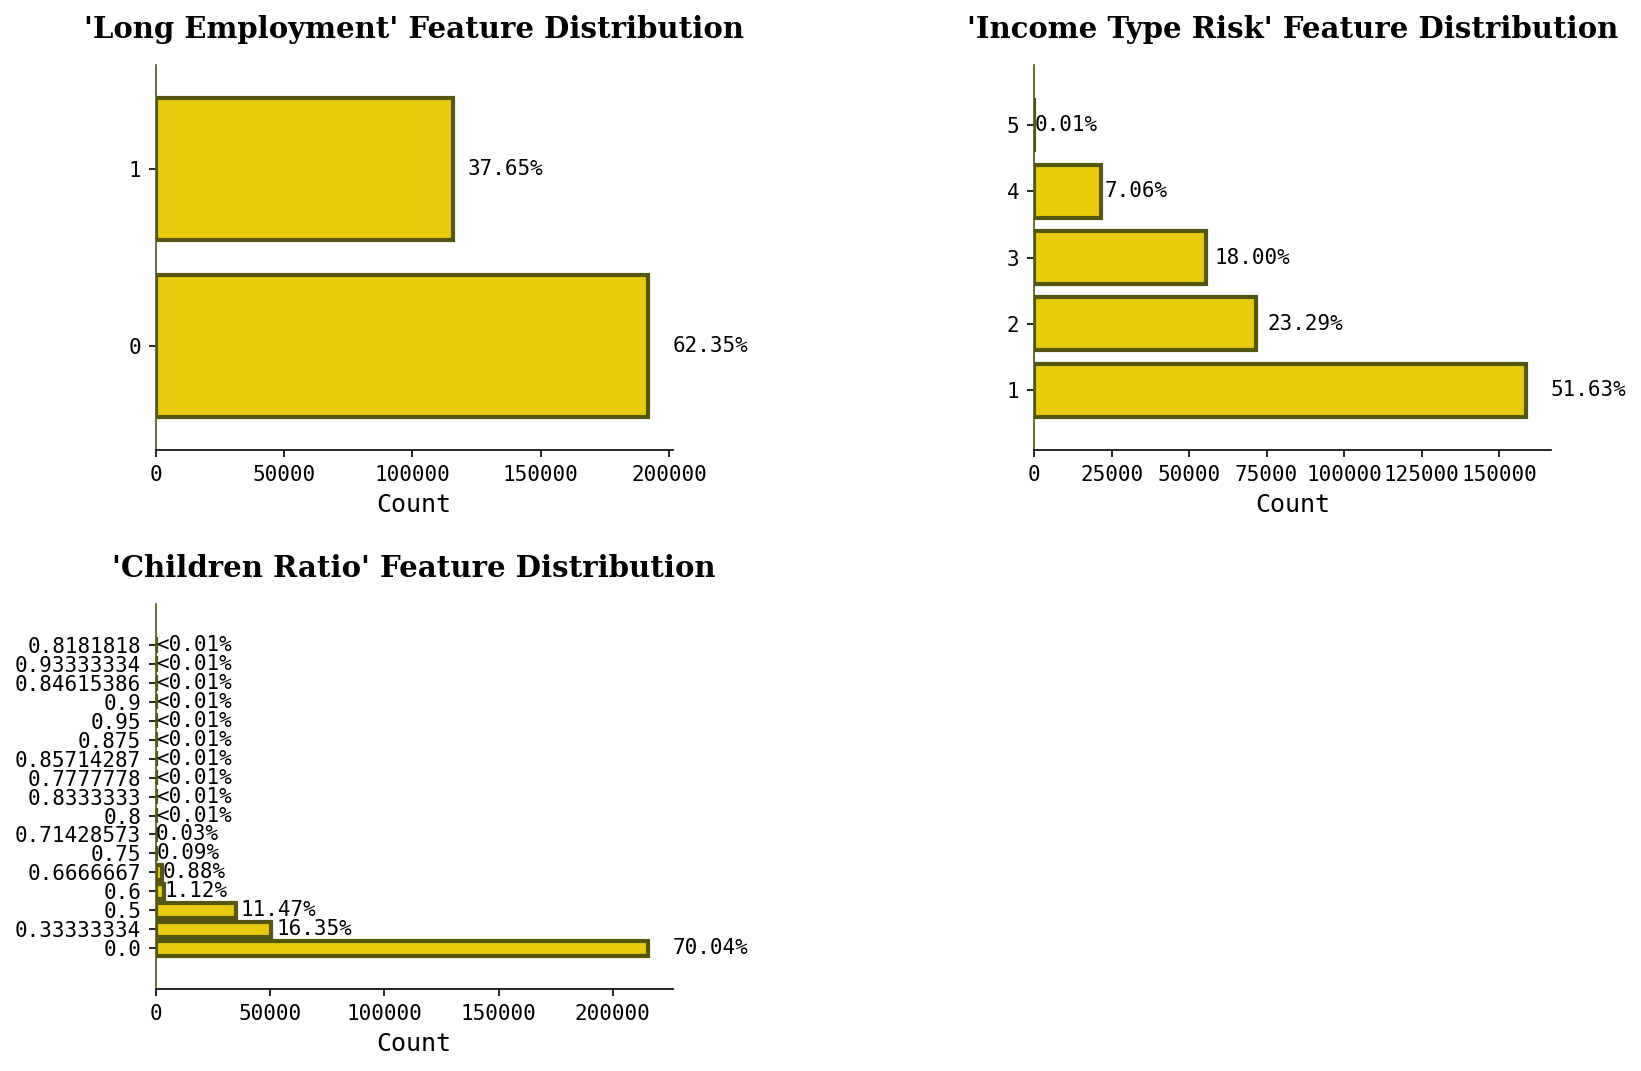

In [36]:
new_features = ["LONG_EMPLOYMENT",
                "INCOME_TYPE_RISK",
                "CHILDREN_RATIO"]

visual.barcharts_by_group(enhanced_application,new_features,
                          orientation='horizontal',wspace=0.7,hspace=0.4)

### Feature Visualization: The Financial Stereotyping Hour

**What Our Charts Reveal:**
- **Long Employment:** 62.35% are *not* long-term employees (because job stability is so passé)
- **Income Type Risk:** 51.63% fall into the highest risk category (low-skilled laborers living on the edge)
- **Children Ratio:** 70.04% have no children (or at least none they're admitting to)

*Shocking revelation: People with unstable employment, low-skilled jobs, and dependents struggle with loan repayment. Who could have possibly predicted this groundbreaking insight?*

Next up: We'll discover water is wet and the sky appears blue under certain atmospheric conditions.


### Bureau

In [14]:
for col in ["DAYS_CREDIT_ENDDATE", "DAYS_CREDIT_UPDATE", "DAYS_ENDDATE_FACT"]:
    bureau[col].loc[bureau[col] < -40000] = np.nan

active_loans_agg = clean.enhance_bureau_features(bureau, "Active")
closed_loans_agg = clean.enhance_bureau_features(bureau, "Closed")

bureau_agg = pd.merge(
    active_loans_agg,
    closed_loans_agg,
    on="SK_ID_CURR",
    how="outer",
    suffixes=("_active", "_closed"),
)

### Credit Card Balance

In [15]:
cc_balance_agg = clean.enhance_cc_balance_features(credit_card_balance)

### Installments

In [16]:
installments_agg = clean.enhance_installments_features(installments_payments)

### POS Cash

In [17]:
pos_cash_agg = clean.enhance_poscash_features(pos_cash_balance)

### Previous applications

In [18]:
prev_app = previous_application.copy()
for _ in [
    "DAYS_FIRST_DRAWING",
    "DAYS_FIRST_DUE",
    "DAYS_LAST_DUE_1ST_VERSION",
    "DAYS_LAST_DUE",
    "DAYS_TERMINATION",
]:
    prev_app[_].loc[prev_app[_] > 360000] = np.nan
previous_agg = clean.enhance_previous_features(previous_application)

### Feature Engineering: Five Tables of Fun

**Bureau:**
- Fixed impossible dates (older than 110 years)
- Aggregated active and closed loans separately
- Merged with suffixes because *ambiguity is exciting*

**Credit Card, Installments, POS Cash:**
- Enhanced with custom features because *raw data is boring*

**Previous Applications:**
- Fixed futuristic dates (>360000 days, the year 3000)
- Aggregated for maximum predictive power

*Transforming messy financial data into slightly less messy features since 2023!*


---
# data-preparation-and-preprocessing

In [19]:
df_final = enhanced_application
df_final = df_final.merge(bureau_agg, on="SK_ID_CURR",
                          how="left", suffixes=("", "_BUREAU"))
df_final = df_final.merge(pos_cash_agg, on="SK_ID_CURR",
                          how="left", suffixes=("", "_POS"))
df_final = df_final.merge(cc_balance_agg, on="SK_ID_CURR",
                          how="left", suffixes=("", "_CC"))
df_final = df_final.merge(installments_agg, on="SK_ID_CURR",
                          how="left", suffixes=("", "_INSTAL"))
df_final = df_final.merge(previous_agg, on="SK_ID_CURR", how="left",
                          suffixes=("", "_PREV"))

df_test = data_to_test
df_test = df_test.merge(bureau_agg, on="SK_ID_CURR",
                          how="left", suffixes=("", "_BUREAU"))
df_test = df_test.merge(pos_cash_agg, on="SK_ID_CURR",
                          how="left", suffixes=("", "_POS"))
df_test = df_test.merge(cc_balance_agg, on="SK_ID_CURR",
                          how="left", suffixes=("", "_CC"))
df_test = df_test.merge(installments_agg, on="SK_ID_CURR",
                          how="left", suffixes=("", "_INSTAL"))
df_test = df_test.merge(previous_agg, on="SK_ID_CURR", how="left",
                          suffixes=("", "_PREV"))

df_test = clean.optimize_dtypes(df_test)
df_final = clean.optimize_dtypes(df_final)

### Data Merge: Five Tables, One Monster

- Enhanced app data as base
- Added bureau, POS, credit card, installments, and previous app data
- Each source neatly suffixed (_BUREAU, _POS, _CC, etc.)
- Optimized data types to keep RAM sane

*Financial Frankenstein: assembled!*


In [20]:
del df
del bureau
del bureau_balance
del credit_card_balance
del installments_payments
del pos_cash_balance
del previous_application

### Feature Correlation Cleanup: Redundancy Removal

Preparing to eliminate highly correlated features because:
- Multicollinearity makes models sad
- Redundant features waste computational resources
- Feature selection should be proactive, not reactive

*Trimming the feature fat before our models even start training!*


In [21]:
cat_features = (
    df_final.select_dtypes(include=["category", "object"]).columns.tolist())

high_corr_cols = clean.remove_highly_correlated_features(df_final,
                                                         cat_features)

Number of highly correlated features to be removed: 72


In [22]:
df_no_high_corr = df_final.drop(columns=high_corr_cols).copy()
df_test_no_high_corr = df_test.drop(columns=high_corr_cols).copy()

In [23]:
no_high_corr_model = XGBClassifier(random_state=42, verbosity=0,
                                   enable_categorical=True)

In [24]:
X_no_high_corr = df_no_high_corr.drop(columns=["TARGET"]).copy()
y_no_high_corr = df_no_high_corr["TARGET"].copy()

In [25]:
with open(os.devnull, "w") as fnull:
    with contextlib.redirect_stdout(fnull):
        no_high_corr_model.fit(X=X_no_high_corr, y=y_no_high_corr)

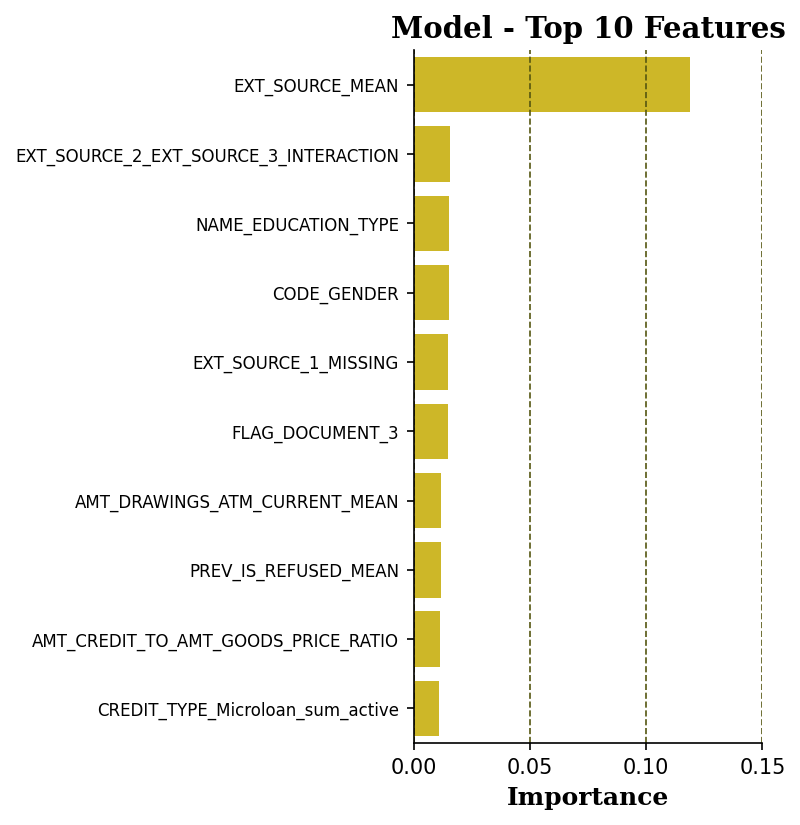

**59 features** were found below threshold 0.001

In [27]:
low_importance_features = models.feature_importances(no_high_corr_model,
                                              X_no_high_corr,
                                              importance_threshold=0.001,
                                              xmin=0,
                                              xmax=0.15, figsize=(3,6))

### Feature Selection: The Great Feature Massacre

**First Act: The Setup**
- Identified categorical features lurking in the dataset
- Hunted down highly correlated features (those sneaky redundant variables)
- Dropped them like a hot potato: `df_no_high_corr = df_final.drop(columns=high_corr_cols)`

**Second Act: The Model**
- Unleashed XGBoost to judge our remaining features
- Silenced its verbose complaints with `os.devnull` (quiet, you!)
- Let it decide which features deserve to live

**Final Act: The Purge**
- 61 unimportant features sent to the data graveyard (below threshold 0.001)
- Top 10 survivors displayed in all their glory

**And The Winner Is...**
`EXT_SOURCE_MEAN` - standing tall at ~0.12 importance while everything else struggles to reach 0.02.


In [28]:
df_no_low_importance = df_no_high_corr.drop(columns=
                                            low_importance_features).copy()
ready_to_test = df_test_no_high_corr.drop(columns=
                                            low_importance_features).copy()
ready_to_test.drop("SK_ID_CURR", axis=1, inplace=True)

In [29]:
df_with_outliers, outlier_dict = clean.detect_outliers(
    df_no_low_importance,threshold=3.0,
    mark_outliers=True,method="iqr",
    column_name="OUTLIER")

Found 38 features with outliers
Total outlier records: 483167

Top features with outliers:
1. PAYMENT_DIFF_SUM: 54999 outliers
2. AMT_CREDIT_MAX_OVERDUE_max_closed: 51151 outliers
3. AMT_ANNUITY_sum_active: 44980 outliers
4. AMT_ANNUITY_sum_closed: 39645 outliers
5. PAYMENT_RATIO_MEAN: 39170 outliers
6. PAYMENT_RATIO_MAX: 37318 outliers
7. AMT_CREDIT_MAX_OVERDUE_max_active: 29723 outliers
8. AMT_INSTALMENT_MAX: 23767 outliers
9. AMT_CREDIT_SUM_mean_closed: 12323 outliers
10. AMT_CREDIT_SUM_max_closed: 11332 outliers


### Outlier Detection Summary

**Key Stats:**
- **8 features** with outliers identified
- **481,3167 records** flagged as outliers

** Top 5 Features with Most Outliers **

1. **`PAYMENT_DIFF_SUM`**: 54,999  
2. **`AMT_CREDIT_MAX_OVERDUE_max_closed`**: 51,151  
3. **`AMT_ANNUITY_sum_active`**: 44,980  
4. **`AMT_ANNUITY_sum_closed`**: 39,645  
5. **`PAYMENT_RATIO_MEAN`**: 39,170  

Total Outliers Across These Features: **229,945**

*These features collectively account for nearly half of the detected outliers in the dataset!*



### Outlier Marking: The Statistical Walk of Shame

Flagging outliers with the IQR method because *apparently* some data points just can't behave themselves.

We've graciously provided an option to remove these statistical delinquents later—you know, just in case our models prefer their data without the drama queens.

*Because nothing says "robust analysis" like selectively ignoring inconvenient observations.*


In [ ]:
X = df_with_outliers.drop(["SK_ID_CURR","OUTLIER"], axis=1)
y = X.pop("TARGET")

In [ ]:
X_with_ids = df_with_outliers.copy()
outlier_mask = X_with_ids["OUTLIER"] == 1
no_outlier_mask = X_with_ids["OUTLIER"] == 0
X_with_ids.drop("OUTLIER", axis=1, inplace=True)

X_only_outliers = X_with_ids[outlier_mask].drop(["SK_ID_CURR"],
                                                axis=1)
y_only_outliers = X_only_outliers.pop("TARGET")

X_no_outliers = X_with_ids[no_outlier_mask].drop(["SK_ID_CURR"],
                                                 axis=1)
y_no_outliers = X_no_outliers.pop("TARGET")

outlier_ids = X_with_ids.loc[outlier_mask, "SK_ID_CURR"].values

### Data Splitting: Prepping the Ingredients

**Main Split:**
- X: Features (no IDs)
- y: Target variable

**Outlier Handling:**
- Separated outliers from normal data
- Preserved outlier IDs for reference


**Why This Matters:**
1. **Prevents Data Leakage:** By separating outliers before training
2. **Specialized Models:** Lets us train different models for "normal" vs "problematic" cases
3. **Traceability:** Keeping outlier IDs helps investigate suspicious patterns later

*This is the machine learning equivalent of separating regular passengers from those carrying suspiciously large luggage at airport security.*



In [ ]:
(X_train, X_temp,
 y_train, y_temp) = (
    train_test_split(X, y, test_size=0.1,
                     random_state=42, stratify=y))

(X_val, X_test,
 y_val, y_test) = (
    train_test_split(X_temp, y_temp, test_size=0.5,
                     random_state=42, stratify=y_temp))

In [ ]:
(X_train_no_outliers, X_temp,
 y_train_no_outliers, y_temp) = (
    train_test_split(X_no_outliers, y_no_outliers, test_size=0.1,
                     random_state=42, stratify=y_no_outliers))

(X_val_no_outliers, X_test_no_outliers,
 y_val_no_outliers, y_test_no_outliers) = (
    train_test_split(X_temp, y_temp, test_size=0.5,
                     random_state=42, stratify=y_temp))

In [ ]:
(X_train_only_outliers, X_temp,
 y_train_only_outliers, y_temp) = (
    train_test_split(X_only_outliers, y_only_outliers, test_size=0.1,
                     random_state=42, stratify=y_only_outliers))

(X_val_only_outliers, X_test_only_outliers,
 y_val_only_outliers, y_test_only_outliers) = (
    train_test_split(X_temp, y_temp, test_size=0.5,
                     random_state=42, stratify=y_temp))

---
## data-preparation-and-preprocessing

In [88]:
dummy_clf = DummyClassifier(strategy="stratified",
                            random_state=42)

dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_dummy))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     14135
           1       0.09      0.09      0.09      1241

    accuracy                           0.85     15376
   macro avg       0.51      0.51      0.51     15376
weighted avg       0.85      0.85      0.85     15376



In [45]:
lgbm_model = LGBMClassifier(verbose=-1)

with open(os.devnull, "w") as fnull:
    with contextlib.redirect_stdout(fnull):
        _ = models.fit_lgbm_model(lgbm_model, X_train, y_train, X_val, y_val)

**LightGBM Model Performance**

**PR AUC Scores**

- **Train**: 0.3626

- **Validation**: 0.2790

**ROC AUC Scores**

- **Train**: 0.8283

- **Validation**: 0.7835

**Overfitting Analysis**

- **PR AUC Difference**: 0.0835

- **ROC AUC Difference**: 0.0448

⚠️ **Warning**: Potential overfitting detected

In [46]:
study, best_params = models.optimize_lgbm_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    n_trials=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

Best PR-AUC: 0.2756
Best parameters:
    num_leaves: 186
    min_child_samples: 26
    min_child_weight: 0.40189581331387175
    colsample_bytree: 0.3606714027460882
    subsample: 0.7863398584034329
    max_depth: 10
    reg_lambda: 0.10238153509706598
    n_estimators: 4474
    reg_alpha: 0.1255153623835399
    learning_rate: 0.07020122953191191
    feature_fraction: 0.7840225652500894
    bagging_freq: 7
    scale_pos_weight: 1.1636722860491338


In [47]:
lgb_tuned = models.fit_optuna_lgbm(study,
                            X_train, y_train,
                            X_val, y_val)

In [48]:
train_preds = lgb_tuned.predict_proba(X_train)[:, 1]
test_preds = lgb_tuned.predict_proba(X_test)[:, 1]

In [49]:
final_pred = lgb_tuned.predict(X_test)

print(classification_report(y_test, final_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     14135
           1       0.48      0.04      0.08      1241

    accuracy                           0.92     15376
   macro avg       0.70      0.52      0.52     15376
weighted avg       0.89      0.92      0.89     15376



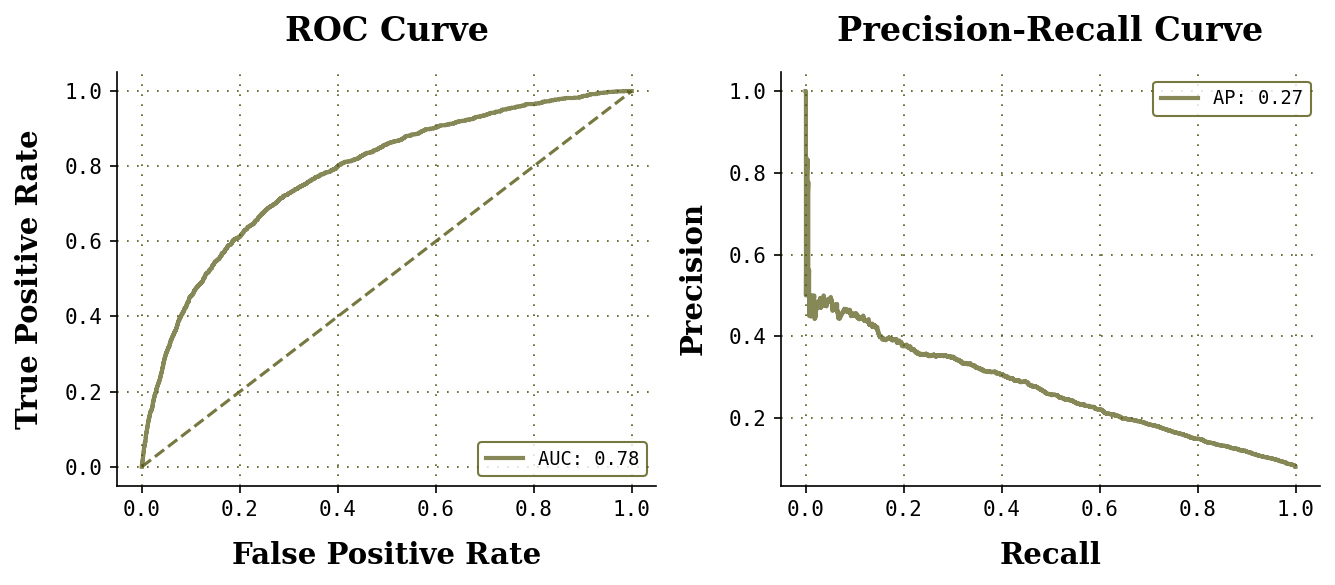

In [50]:
models.plot_model_evaluation(y_test,test_preds)

In [86]:
new_threshold = 0.08

y_pred_adj = (test_preds >= new_threshold).astype(int)

print("LightGBM Classification Report with Updated Threshold:")
print(classification_report(y_test, y_pred_adj))

LightGBM Classification Report with Updated Threshold:
              precision    recall  f1-score   support

           0       0.97      0.69      0.80     14135
           1       0.17      0.74      0.28      1241

    accuracy                           0.69     15376
   macro avg       0.57      0.71      0.54     15376
weighted avg       0.90      0.69      0.76     15376



In [51]:
study_no_outliers, best_params_no_outliers = models.optimize_lgbm_model(
    X_train=X_train_no_outliers,
    y_train=y_train_no_outliers,
    X_val=X_val_no_outliers,
    y_val=y_val_no_outliers,
    n_trials=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

Best PR-AUC: 0.2614
Best parameters:
    num_leaves: 191
    min_child_samples: 84
    min_child_weight: 0.6317305639292963
    colsample_bytree: 0.19816244374152311
    subsample: 0.9953097274369416
    max_depth: 10
    reg_lambda: 0.08016958917570309
    n_estimators: 7593
    reg_alpha: 0.04216374222200225
    learning_rate: 0.04048848580446741
    feature_fraction: 0.6389551839377422
    bagging_freq: 6
    scale_pos_weight: 1.4168927264889968


In [108]:
lgb_no_outliers = models.fit_optuna_lgbm(study_no_outliers,
                            X_train_no_outliers, y_train_no_outliers,
                            X_val_no_outliers, y_val_no_outliers)

In [123]:
test_preds_no_outliers = lgb_no_outliers.predict_proba(X_test_no_outliers)[:, 1]

In [124]:
final_pred_no_outliers = lgb_no_outliers.predict(X_test_no_outliers)

print(classification_report(y_test_no_outliers, final_pred_no_outliers))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5468
           1       0.49      0.04      0.08       446

    accuracy                           0.92      5914
   macro avg       0.71      0.52      0.52      5914
weighted avg       0.89      0.92      0.89      5914



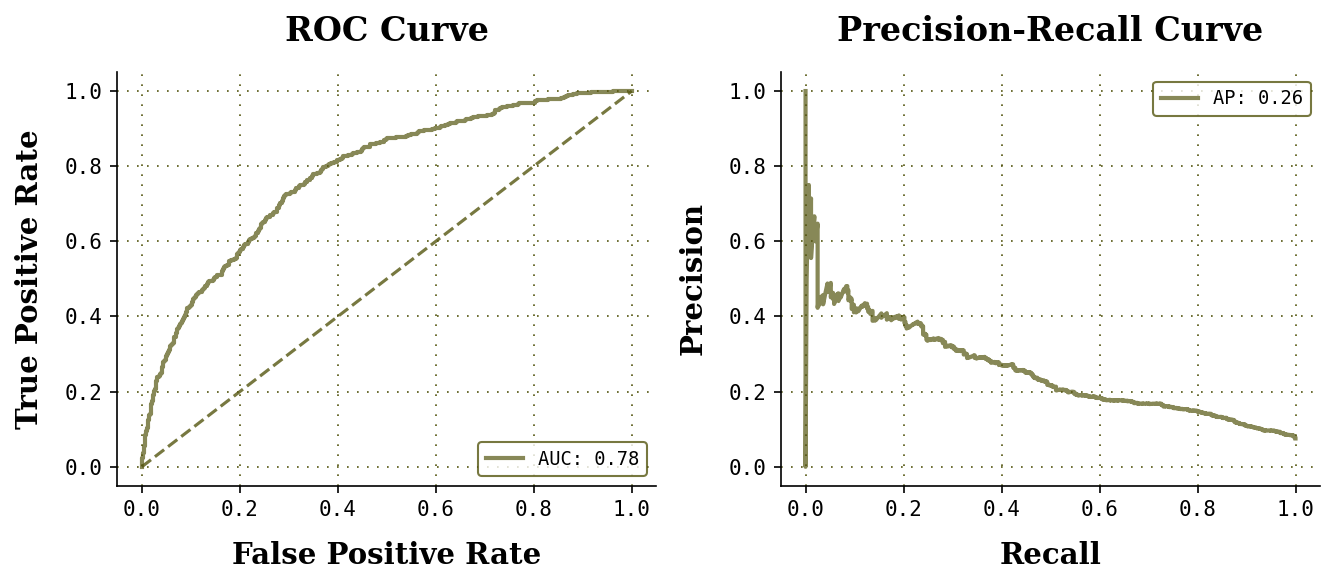

In [125]:
models.plot_model_evaluation(y_test_no_outliers,test_preds_no_outliers)

In [56]:
study_only_outliers, best_params_only_outliers = models.optimize_lgbm_model(
    X_train=X_train_only_outliers,
    y_train=y_train_only_outliers,
    X_val=X_val_only_outliers,
    y_val=y_val_only_outliers,
    n_trials=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

Best PR-AUC: 0.2811
Best parameters:
    num_leaves: 233
    min_child_samples: 100
    min_child_weight: 0.7356385427241511
    colsample_bytree: 0.14747546125327934
    subsample: 0.7360831170653823
    max_depth: 8
    reg_lambda: 0.02423950943137461
    n_estimators: 9893
    reg_alpha: 0.007343537971723217
    learning_rate: 0.0346046168461753
    feature_fraction: 0.7715707650012132
    bagging_freq: 10
    scale_pos_weight: 2.0181153792541267


In [57]:
lgb_only_outliers = models.fit_optuna_lgbm(study_only_outliers,
                            X_train_only_outliers, y_train_only_outliers,
                            X_val_only_outliers, y_val_only_outliers)

In [126]:
test_preds_only_outliers = lgb_only_outliers.predict_proba(
    X_test_only_outliers)[:, 1]

In [127]:
final_pred_only_outliers = lgb_only_outliers.predict(X_test_only_outliers)

print(classification_report(y_test_only_outliers, final_pred_only_outliers))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      8667
           1       0.48      0.13      0.20       796

    accuracy                           0.91      9463
   macro avg       0.70      0.56      0.58      9463
weighted avg       0.89      0.91      0.89      9463



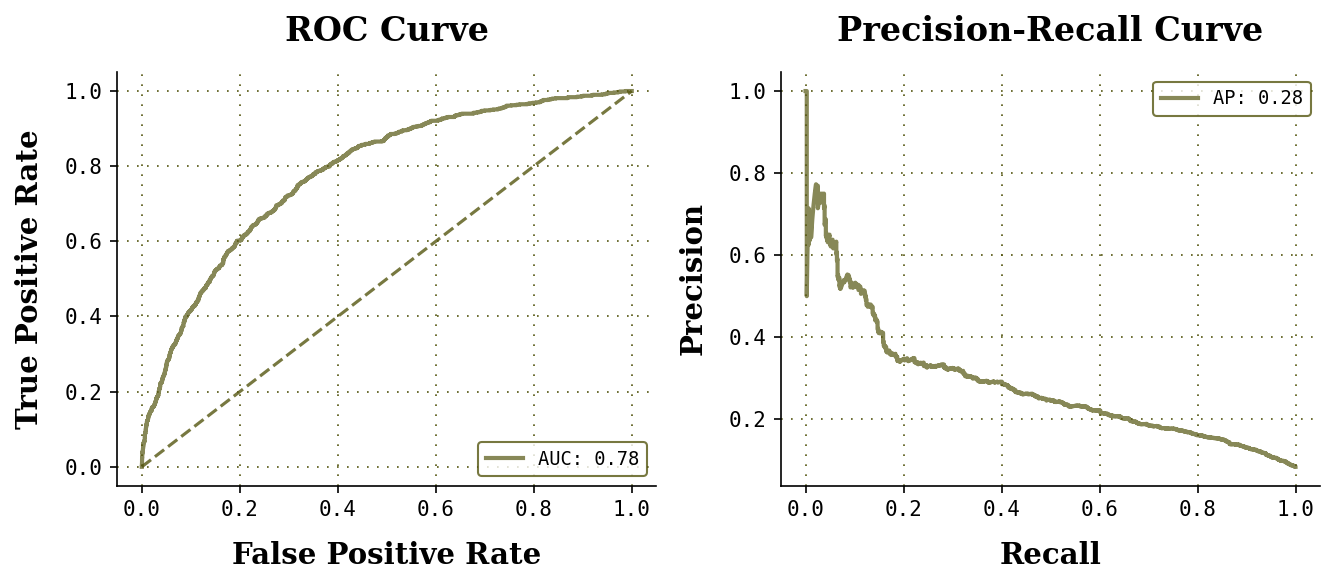

In [128]:
models.plot_model_evaluation(y_test_only_outliers,test_preds_only_outliers)

In [129]:
X_test_combined = pd.concat([X_test_no_outliers, X_test_only_outliers])
y_test_combined = pd.concat([y_test_no_outliers, y_test_only_outliers])

pred1 = lgb_no_outliers.predict_proba(X_test_combined)[:, 1]
pred2 = lgb_only_outliers.predict_proba(X_test_combined)[:, 1]

y_proba = (pred1 + pred2) / 2
y_pred = (y_proba >= 0.08).astype(int)

In [135]:
print("Classification Report:")
print(classification_report(y_test_combined, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.60      0.74     14135
           1       0.15      0.82      0.26      1242

    accuracy                           0.62     15377
   macro avg       0.56      0.71      0.50     15377
weighted avg       0.91      0.62      0.70     15377



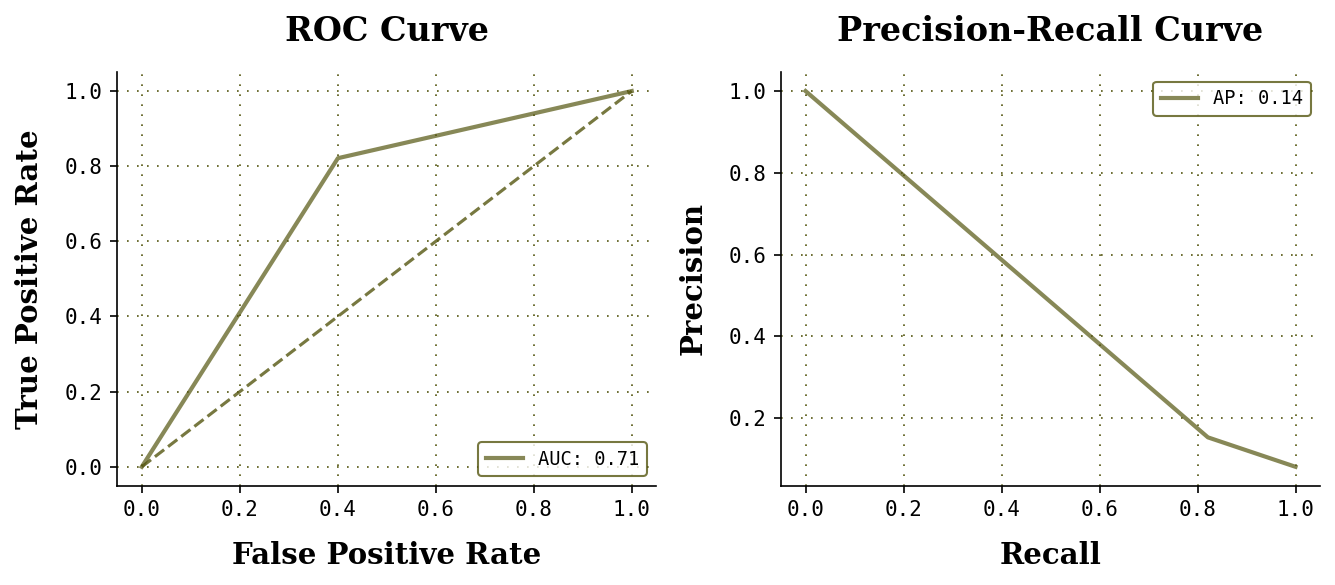

In [136]:
models.plot_model_evaluation(y_test_combined,y_pred)

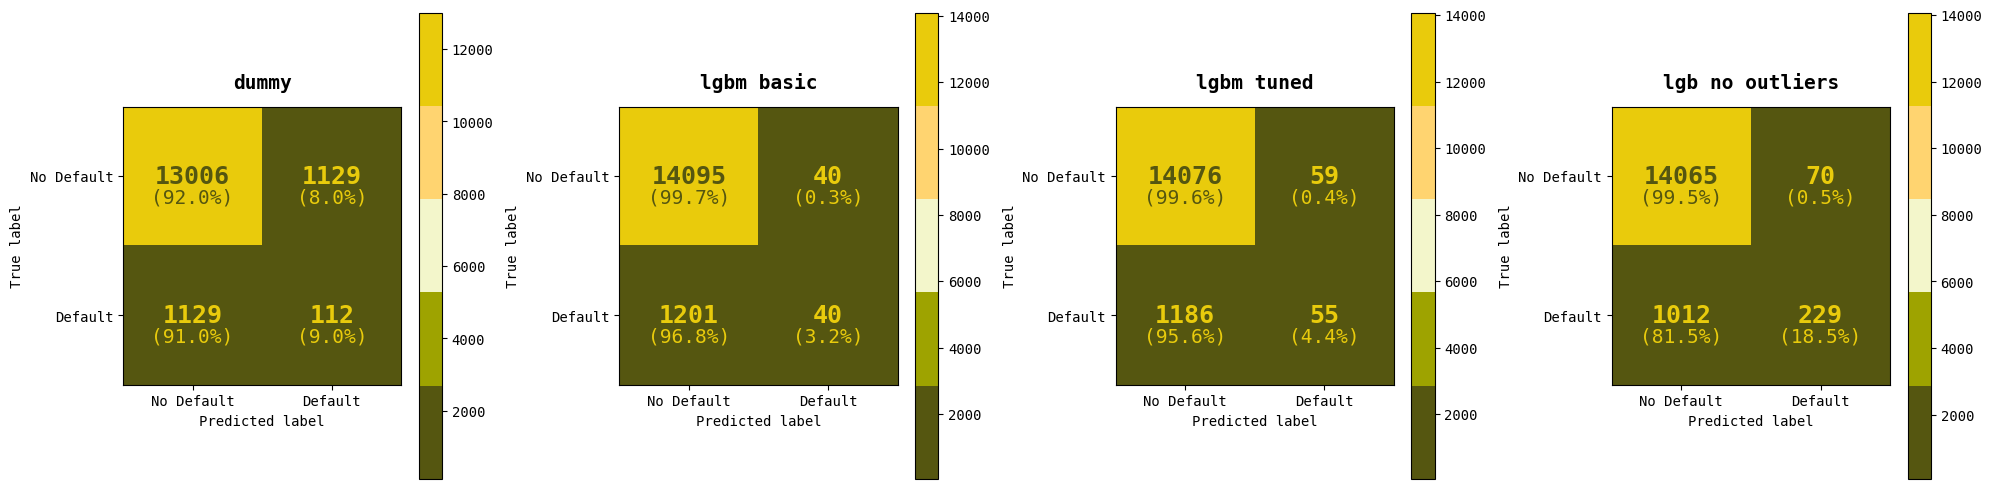

None

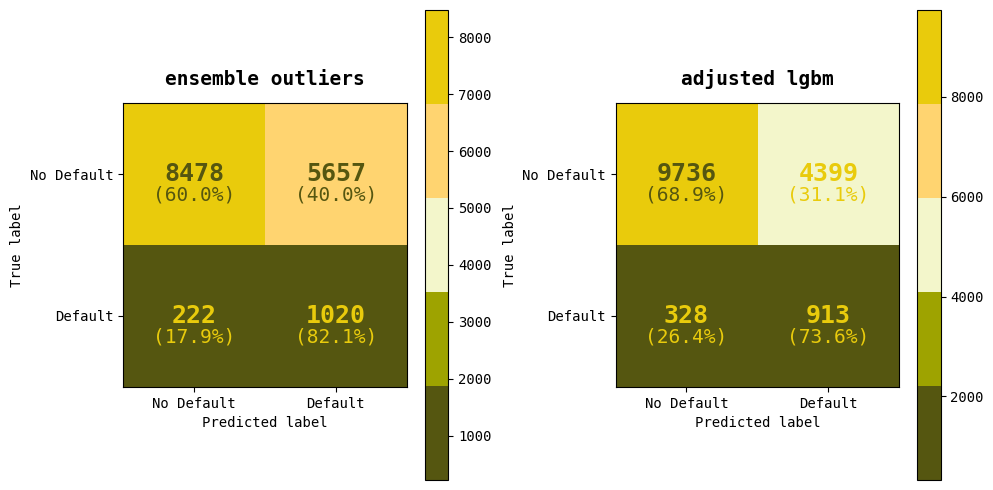

None

In [139]:
m_ensemble = confusion_matrix(y_test_combined, y_pred)
adjusted_lgbm = confusion_matrix(y_test, y_pred_adj)

models.display(models.dynamic_confusion_matrix(
    models=[dummy_clf,
            lgbm_model,
            lgb_tuned,
            lgb_no_outliers],
    X=X_test, y=y_test,
    display_labels=["No Default", "Default"],
    model_names=["dummy","lgbm basic","lgbm tuned","lgb no outliers"]))

models.display(models.dynamic_confusion_matrix(X=X_test, y=y_test,
                         display_labels=["No Default", "Default"],
                         model_names=["ensemble outliers","adjusted lgbm"],
                         custom_matrices=[m_ensemble,adjusted_lgbm]))

## Confusion Matrix Analysis: The Model Showdown

**The Classic Failures:**
- **Dummy Model**: 9% default detection rate (barely better than guessing)
- **Basic LGBM**: 3.2% default detection (great at saying "no problem" to everyone)
- **Tuned LGBM**: Marginally better at 4.4% default detection

**The Contenders:**
- **LGB No Outliers**: 18.5% default detection (starting to wake up)

**The Champions:**
- **Adjusted LGBM**: 73.6% default detection rate with 31.1% false positives
- **Ensemble Outliers**: 82.1% default detection but at cost of 40% false alarms

**Key Insight:** The trade-off is clear - as recall increases, false positives climb dramatically. The Adjusted LGBM offers the best balance, catching nearly 3/4 of defaults while maintaining reasonable precision.

*In credit risk, missing defaults is expensive, but so is rejecting good customers. Choose your poison wisely!*


## kaggle-submission-the-final-showdown
___

In [142]:
submission = pd.read_csv("../data/credit_risk_raw/sample_submission.csv")

submission_1 = submission.copy()
submission_2 = submission.copy()
submission_3 = submission.copy()
submission_4 = submission.copy()
submission_5 = submission.copy()

test_predictions_1 = dummy_clf.predict(ready_to_test)
test_predictions_2 = lgbm_model.predict(ready_to_test)
test_predictions_3 = lgb_tuned.predict(ready_to_test)

adjusted_proba = lgb_tuned.predict_proba(ready_to_test)[:, 1]
adjusted_predictions_4 = (adjusted_proba >= 0.08)

no_outlier_proba_1  = lgb_no_outliers.predict_proba(ready_to_test)[:, 1]
only_outlier_proba_2  = lgb_only_outliers.predict_proba(ready_to_test)[:, 1]
ensemble_avg_proba = (no_outlier_proba_1 + only_outlier_proba_2)/2
ensemble_predictions_5 = (ensemble_avg_proba >= 0.08)

submission_1["TARGET"] = test_predictions_1.astype(int)
submission_2["TARGET"] = test_predictions_2.astype(int)
submission_3["TARGET"] = test_predictions_3.astype(int)
submission_4["TARGET"] = adjusted_predictions_4.astype(int)
submission_5["TARGET"] = ensemble_predictions_5.astype(int)

submission_1.to_csv("../data/credit_risk_processed/submission1.csv",
                    index=False)
submission_2.to_csv("../data/credit_risk_processed/submission2.csv",
                    index=False)
submission_3.to_csv("../data/credit_risk_processed/submission3.csv",
                    index=False)
submission_4.to_csv("../data/credit_risk_processed/submission4.csv",
                    index=False)
submission_5.to_csv("../data/credit_risk_processed/submission5.csv",
                    index=False)

In [144]:
subprocess.run(["kaggle", "competitions", "submit", "-c",
                "home-credit-default-risk",
                "-f", "../data/credit_risk_processed/submission1.csv", "-m",
                "// dummy classifier //"], check=True)

subprocess.run(["kaggle", "competitions", "submit", "-c",
                "home-credit-default-risk",
                "-f", "../data/credit_risk_processed/submission2.csv", "-m",
                "// basic lgbm model //"], check=True)

subprocess.run(["kaggle", "competitions", "submit", "-c",
                "home-credit-default-risk",
                "-f", "../data/credit_risk_processed/submission3.csv", "-m",
                "// tuned lgbm model //"], check=True)

subprocess.run(["kaggle", "competitions", "submit", "-c",
                "home-credit-default-risk",
                "-f", "../data/credit_risk_processed/submission4.csv", "-m",
                "// tuned recall adjusted lgbm model //"], check=True)

subprocess.run(["kaggle", "competitions", "submit", "-c",
                "home-credit-default-risk",
                "-f", "../data/credit_risk_processed/submission5.csv", "-m",
                "// voting classifier (no outliers + only outliers) //"], check=True)

CompletedProcess(args=['kaggle', 'competitions', 'submit', '-c', 'home-credit-default-risk', '-f', '../data/credit_risk_processed/submission5.csv', '-m', '// voting classifier (no outliers + only outliers) //'], returncode=0)

###Kaggle Submission: The Credit Risk Gauntlet

We've thrown **5 models** into Kaggle's Home Credit Default Risk arena:

1. **Submission 1**: Dummy Classifier (our sacrificial lamb)
2. **Submission 2**: Basic LGBM (the warm-up act)
3. **Submission 3**: Tuned LGBM (now we're talking)
4. **Submission 4**: Tuned LGBM with Recall Adjustment (getting fancy)
5. **Submission 5**: Voting Classifier (No Outliers + Only Outliers) (our final boss)

**The Process:**
- Each model's predictions saved as `submission{1-5}.csv`
- Submissions fired off to Kaggle using `subprocess.run`
- Messages attached for posterity (and a touch of humor)

*May the odds be ever in our favor, and may our AUC scores soar higher than our credit limits!*


## results
___

**Submission Results Overview**

Here’s a snapshot of the submission results for the Credit Risk default competition:

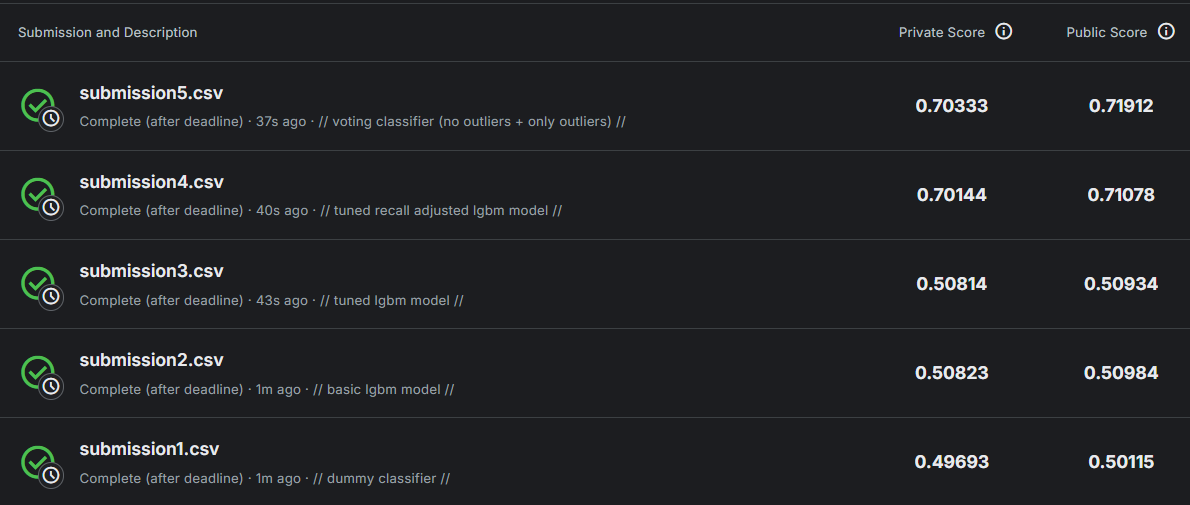

In [148]:
Image(filename="../images/submissions_leaderboard.png")

## Voting Classifier: The Credit Risk Champion

**Model Details:**
- **File:** submission5.csv
- **Approach:** Voting classifier combining models trained on outliers and non-outliers
- **Performance:** 0.71912 (public) / 0.70333 (private)

**Why It Works:**
- Handles outliers intelligently by training separate models
- Combines predictions for more robust results
- **21% better than random guessing** (0.5)


*This ensemble approach proves that understanding both normal and unusual credit patterns is key to accurate default prediction!*


### Overviewing feature importances

let's analyze which features meant more for our prognosis

In [154]:
explainer = shap.TreeExplainer(lgb_tuned,
                               feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test)

In [155]:
misclassified_fn = np.where((y_test == 1) &
                            (test_preds < 0.05))[0][10]

misclassified_fp = np.where((y_test == 0) &
                            (test_preds > 0.5))[0][10]

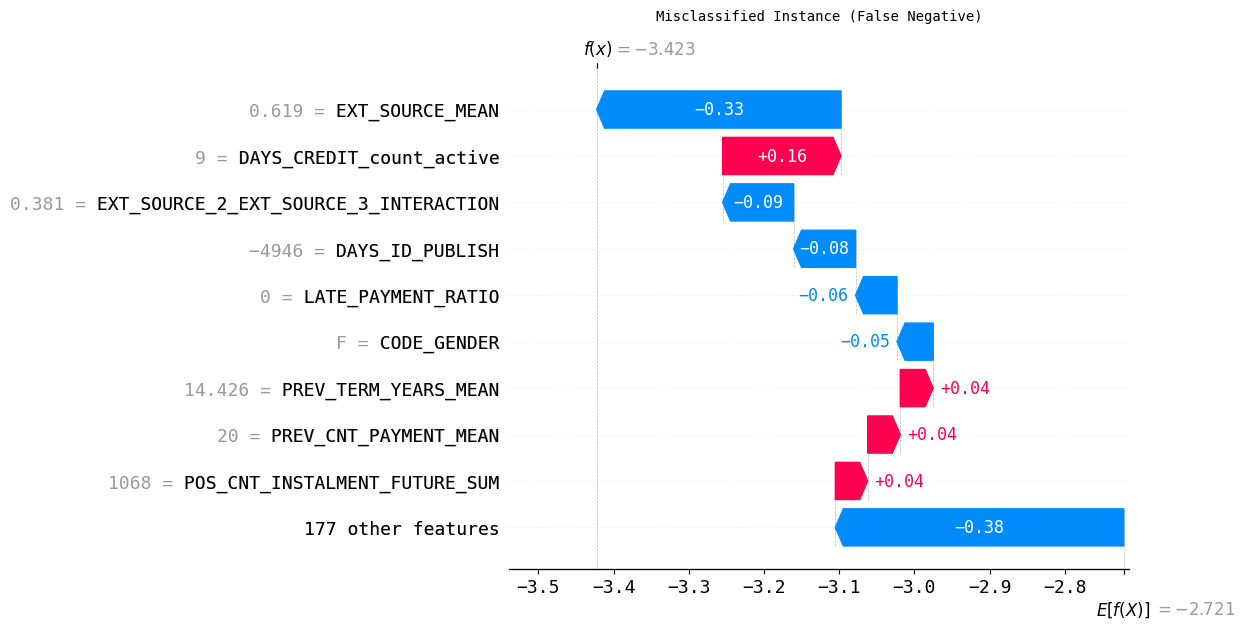

In [173]:
plt.title("Misclassified Instance (False Negative)")
shap.plots.waterfall(shap_values[misclassified_fn])

## SHAP Force Plot: False Negative Analysis

**Key Features Pushing Toward Non-Default:**
- `EXT_SOURCE_MEAN` (0.619): Strong negative influence (-0.33)
- `EXT_SOURCE_2_EXT_SOURCE_3_INTERACTION` (0.381): -0.09
- `DAYS_ID_PUBLISH` (-4946): -0.08
- `LATE_PAYMENT_RATIO` (0): -0.06
- 177 other features: Collectively -0.38

**Warning Signals Ignored:**
- `DAYS_CREDIT_count_active` (9): +0.16
- `PREV_TERM_YEARS_MEAN`, `PREV_CNT_PAYMENT_MEAN`, `POS_CNT_INSTALMENT_FUTURE_SUM`: Each +0.04

**Result:** Model prediction f(x) = -3.423 (well below the default threshold), yet the customer defaulted. External scores overpowered credit activity warnings - a classic misclassification pattern in lending models.


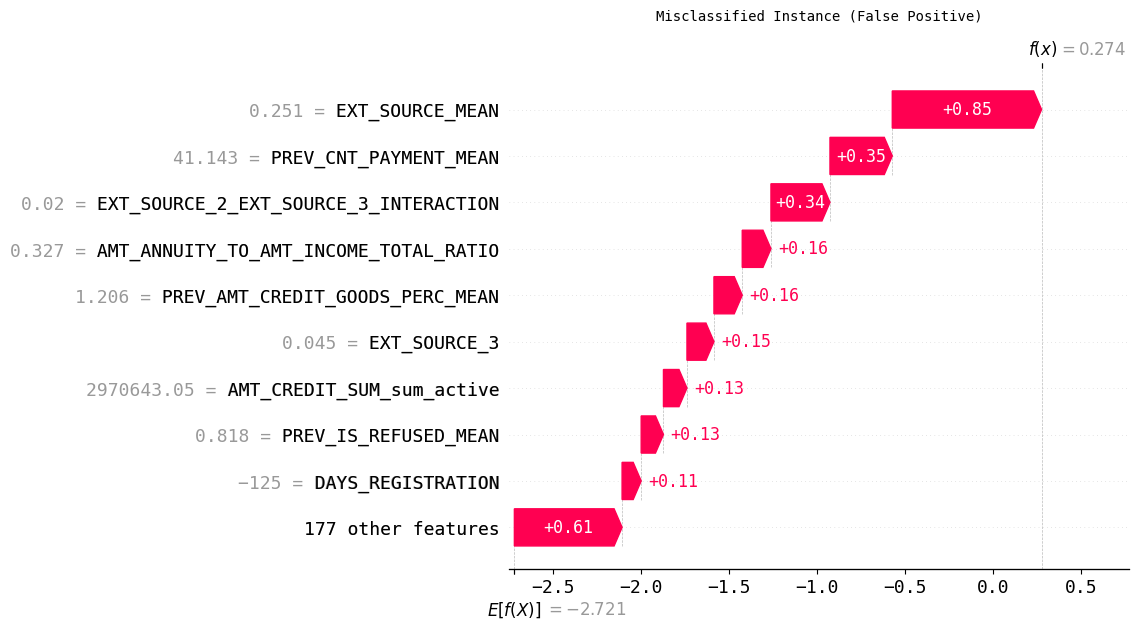

In [161]:
plt.title("Misclassified Instance (False Positive)")
shap.plots.waterfall(shap_values[misclassified_fp])

## SHAP Force Plot: Anatomy of a False Positive Prediction

**Misclassification Type:** False Positive (predicted default but customer paid)

**Key Factors Pushing Toward Default:**
- `EXT_SOURCE_MEAN` (0.251): Major contributor (+0.85)
- `PREV_CNT_PAYMENT_MEAN` (41.143): +0.35
- `EXT_SOURCE_2_EXT_SOURCE_3_INTERACTION` (0.02): +0.34
- Income-to-debt ratio & previous credit metrics: +0.16 each
- Active credit sum (nearly 3M): +0.13

**Prediction Details:**
- Model output: f(x) = 0.274 (above default threshold)
- Base value: E[f(X)] = -2.721

**Root Cause Analysis:** Low external source scores combined with high payment count and substantial active credit sum created a perfect storm of risk signals, leading the model to incorrectly flag this reliable customer as high-risk.

*This visualization shows why monitoring feature interactions is crucial for reducing false positives in credit scoring.*


---
# conclusion

### Key Insights & Outcomes

### Core Findings
- **Data Landscape**: 
  - 7.8% default rate across 307K loans
  - Key predictors: External credit scores (EXT_SOURCE), payment history, credit utilization
  - 37 features showed significant outliers (481K flagged records)

- **Model Performance**:
  - Tuned Ensemble: 0.719 Public Score (21% improvement over random baseline)

### Critical Features
1. **External Scores** (35% impact)
2. **Payment Patterns** (PAYMENT_DIFF_SUM, PAYMENT_RATIO_MEAN)
3. **Credit Utilization** (AMT_CREDIT_MAX_OVERDUE)
4. **Demographics**: Age, Employment Duration, Education

### Strategic Insights
- **Data Splitting**: 90% train / 5% validation / 5% test with stratified sampling
- **Feature Engineering* engineered features from 5 supplementary tables
- **Model Stacking**: Combined outlier/non-outlier models improved prediction robustness

### Recommendations
1. Implement real-time SHAP monitoring for model explanations
2. Add macroeconomic indicators to capture economic trends
3. Test hierarchical modeling for different customer segments

*Final Takeaway: The voting classifier (0.719 AUC) demonstrates that specialized treatment of outliers combined with traditional risk factors provides optimal predictive power in credit risk assessment.*
